# Recommender Systems

# Библиотеки

In [ ]:
!pip install implicit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 16.6 MB/s eta 0:00:00


In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 4.8 MB/s eta 0:00:00


In [ ]:
from abc import ABC, abstractmethod
from typing import Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
from sklearn.preprocessing import LabelEncoder
from tqdm.auto import tqdm

import seaborn as sns
sns.set_style('darkgrid')

/usr/local/lib/python3.10/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ml_tink/kion_data.zip

Archive:  /content/drive/MyDrive/ml_tink/kion_data.zip
   creating: kion_data/
  inflating: __MACOSX/._kion_data    
  inflating: kion_data/.DS_Store     
  inflating: __MACOSX/kion_data/._.DS_Store  
  inflating: kion_data/users.csv     
  inflating: kion_data/train_data.csv  
  inflating: kion_data/items.csv     
  inflating: kion_data/test_data.csv  


# Данные

В качестве данных будем использовать датасет от MTS.AI: [kion-data](https://arxiv.org/pdf/2209.00325.pdf).  
Это информация о просмотрах пользователей различных фильмов и сериалов с названиями, описаниями и прочими фичами.
**Обратите внимание, что вы можете парсить интернет, для получения дополнительных фичей! Только не забудьте описать, какие фичи вы взяли и где вы их достали!**   
Мы заранее поделили выборки на тренировочную и тестовую части, поэтому **просим** вас придерживаться следующих правил: с тренировочными данными разрешается делать **всё что угодно**, тестовую же часть **запрещается изменять**!  

Датасет представляет из себя 4 файла: тренировочную часть (`train_data.csv`), тестовую часть(`test_data.csv`), описание пользователей(`users.csv`) и описание айтемов(`items_.csv`).

In [ ]:
data_folder = "kion_data/"

users_df = pd.read_csv(data_folder + "users.csv")
items_df = pd.read_csv(data_folder + "items.csv")
train_part = pd.read_csv(data_folder + "train_data.csv", parse_dates=["last_watch_dt"])
test_part = pd.read_csv(data_folder + "test_data.csv")
test_part = test_part.groupby("user_id").agg({"ground_truth": list}).reset_index()


# Пользователи

In [ ]:
users_df.head()

,user_id,age,income,sex,kids_flg
0,973171,age_25_34,income_60_90,М,1
1,962099,age_18_24,income_20_40,М,0
2,721985,age_45_54,income_20_40,Ж,0
3,704055,age_35_44,income_60_90,Ж,0
4,846063,age_35_44,income_40_60,Ж,1


In [ ]:
users_df['user_id'].nunique()

366088

## Какие есть признаки?

1. `user_id` – индентификатор пользователя, уникален для каждого
2. `age` – категориальный признак, показывающий возрастную группу пользователя
3. `income` – категориальный признак, показывающий зарплатную группу пользователя
4. `sex` – пол пользователя
5. `kids_flg` – наличие детей у пользователя


# Айтемы

In [ ]:
items_df.head(2)

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,NaN,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,NaN,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."


## Какие есть признаки?

1. `item_id` – индентификатор айтема, уникален для каждого
2. `content_type` – категориальный признак, тип айтема (фильм, сериал и т.д.)
3. `title` – Название на русском языке
4. `title_orig` – Название на языке оригинала
5. `release_year` – год выхода
6. `genres` – список жанров (представлен строкой)
7. `countries` – страна издания
8. `for_kids` – предназначен для детей
9. `age_rating` – возрастной рейтинг картины
10. `studios` – студия, выпустившая картину
11. `directors` – режиссер(ы)
12. `actors` – актёры
13. `description` – описание (на русском)
14. `keywords` – ключевые слова, описывающие картину


# Просмотры пользователей

### Тренировачные данные

In [ ]:
print(f"Число тренировачных интеракций: {len(train_part):,}")
train_part.head()

Число тренировачных интеракций: 1,224,560


,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0


### Тестовые данные

In [ ]:
print(f"Число тестовых пользователей: {len(test_part):,}")
test_part.head()

Число тестовых пользователей: 18,693


,user_id,ground_truth
0,30,"[8584, 3031, 15363]"
1,144,"[3800, 11987, 10942]"
2,241,"[14841, 6162, 5808, 15266]"
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]"
4,475,"[6214, 3734, 6686]"


### Обратите внимание, что формат данных тестовой и тренировочной частей отличается.
#### Это сделано для того, чтобы вы могли использовать дополнительную информацию в своих моделях, например такую как время просмотра (`total_dur`), процент просмотра(`watched_pct`), а так же дату последнего просмотра (`last_watch_dt`)
#### При этом на тестовых данных такой информации нет, так как мы не можем смотреть в будущее.     

#### Тестовые данные также приведены в удобный для подсчета метрик вид.

# Метрики

#### Кратко расскажем про метрики, которые мы будем использовать для измерения качества наших моделей.  

Мы будем смотреть всего на две метрики: **ndcg** и **recall**.  
Все метрики измеряются до какой-то позиции, у нас это будет **10**. То есть мы отдаем 10 самых подходящих пользователю айтемов по мнению модели и говорим, что это и есть наши рекомендации, качество которых мы хотим оценить.  

**ndcg** показывает, как модель справляется с задачей ранжирования, то есть ставит просмотренные айтемы выше непросмотренных
**recall** показывает, как много релевантных айтемов модель выдаёт в топе (смысл как в задаче классификации)

*Для обоих метрик лучше та, которая как можно ближе к **1.0***

Не бойтесь, если вам сейчас что-то непонятно, подробнее про метрики мы расскажем на смене или можете почитать в интернете:)

#### Ниже представлен код реализации, пожалуйста, не меняйте его!

In [ ]:
# ACHTUNG! DO NOT TOUCH

def ndcg_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    at = len(predicted)
    relevance = np.array([1 if x in predicted else 0 for x in gt_items])
    # DCG uses the relevance of the recommended items
    rank_dcg = dcg(relevance)
    if rank_dcg == 0.0:
        return 0.0

    # IDCG has all relevances to 1 (or the values provided), up to the number of items in the test set that can fit in the list length
    ideal_dcg = dcg(np.sort(relevance)[::-1][:at])

    if ideal_dcg == 0.0:
        return 0.0

    ndcg_ = rank_dcg / ideal_dcg

    return ndcg_


def dcg(scores: np.ndarray) -> float:
    return np.sum(
        np.divide(np.power(2, scores) - 1, np.log2(np.arange(scores.shape[0], dtype=np.float64) + 2)), dtype=np.float64
    )


def recall_metric(gt_items: np.ndarray, predicted: np.ndarray) -> float:
    n_gt = len(gt_items)
    intersection = len(set(gt_items).intersection(set(predicted)))
    return intersection / n_gt


def evaluate_recommender(df: pd.DataFrame, model_preds_col: str, gt_col: str = "ground_truth") -> Dict[str, float]:
    metric_values = []

    for _, row in df.iterrows():
        metric_values.append(
            (ndcg_metric(row[gt_col], row[model_preds_col]), recall_metric(row[gt_col], row[model_preds_col]))
        )

    return {"ndcg": np.mean([x[0] for x in metric_values]), "recall": np.mean([x[1] for x in metric_values])}

#### Класс, от которого стоит наследовать все ваши модели, чтобы эксперименты было проще проводить

In [ ]:
class BaseRecommender(ABC):
    def __init__(self):
        self.trained = False

    @abstractmethod
    def fit(self, df: pd.DataFrame) -> None:
        # реализация может быть любой, никаких ограничений

        # не забудьте про
        self.trained = True

    @abstractmethod
    def predict(self, df: pd.DataFrame, topn: int = 10) -> List[np.ndarray]:
        # реализация может быть любой, НО
        # должен возвращать список массивов из item_id, которые есть в `item_df`, чтобы корректно работал подсчет метрик
        pass

### Перейдем к моделям, начнем с супер простого подхода – давайте всем рекомендовать топ популярных (по числу просмотров) айтемов

# Baseline #1 – Топ Популярных

In [ ]:
class TopPopular(BaseRecommender):
    def __init__(self):
        super().__init__()

    def fit(self, df: pd.DataFrame, item_id_col: str = "item_id") -> None:
        # считаем популярность айтемов
        self.recommendations = df[item_id_col].value_counts().index.values
        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10) -> np.ndarray:
        assert self.trained
        # возвращаем для всех одно и то же
        return [self.recommendations[:topn]] * len(df)


toppop = TopPopular()
toppop.fit(train_part)
test_part["toppopular_recs"] = toppop.predict(test_part)
test_part.head()

,user_id,ground_truth,len,toppopular_recs
0,30,"[8584, 3031, 15363]",3,"[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
1,144,"[3800, 11987, 10942]",3,"[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
2,241,"[14841, 6162, 5808, 15266]",4,"[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
3,259,"[16509, 10509, 4491, 5434, 4471, 10772, 817]",7,"[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."
4,475,"[6214, 3734, 6686]",3,"[10440, 15297, 13865, 9728, 4151, 2657, 3734, ..."


##### Посмотрим на метрики, для этого передаем тестовый датафрейм и колонку с предсказаниями, в нашем случае это `toppopular_recs`  

In [ ]:
evaluate_recommender(df=test_part, model_preds_col="toppopular_recs")


{'ndcg': 0.17037237918248196, 'recall': 0.0763696799665908}

#### Не пугайтесь таких маленьких значений, в RecSys задачах часто очень тяжело подстроиться под данные, поэтому абсолютные значения невелики. Чтобы по-настоящему оценить качество вашей модели, нужно сранвить ее с каким-то простым решением, которое можно считать отправной точкой. Наш бейзлайн с популярными фильмами как раз подходит!

### Теперь возьмем подход посложнее, уже математически подкованный
Мы можем представить просмотры пользователей, как матрицу, где по столбцам будут отложены айтемы, а по строкам – пользователи. В `[i,j]` ячейке будет стоять 1, если пользователь смотрел фильм/сериал и 0, если нет.  
Тогда нашей задачей будет разложить исходную матрицу на две: матрицу пользователей и матрицу айтемов, перемножив которые, мы бы максимально приблизили известные нам единички.
Такой подход позволит нам заполнить все пропуски в нашей матрице, то есть все нули.

Для этого метода будем использовать модель **Alternating Least Squares (ALS)**. Она оптимизирует наши матрицы таким образом, чтобы мы хорошо восстанавливали все единички.
Подробнее про модель можно почитать в [документации](https://benfred.github.io/implicit/), или, например, [тут](https://medium.com/radon-dev/als-implicit-collaborative-filtering-5ed653ba39fe), или как всегда – в интернете.

![Alt text](./images/mf.png)


# Baseline #2 – Матричное разложение

In [ ]:
class ALS(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(
        self, factors: int = 100, regularization: float = 0.01, alpha: float = 1.0, iterations: int = 5, **kwargs
    ) -> None:
        super().__init__()
        self.model = AlternatingLeastSquares(
            factors=factors, regularization=regularization, alpha=alpha, iterations=iterations, **kwargs
        )
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10, to_filter: pd.DataFrame = None) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            to_filter_items = None
            if to_filter is not None and len(to_filter) > 0:
                orig_user = self.user_encoder.inverse_transform([user])[0]
                vals = to_filter.loc[to_filter['user_id'] == orig_user, 'ground_truth'].values
                if len(vals) > 0:
                    vals = np.intersect1d(vals[0], self.item_encoder.classes_)
                    to_filter_items = self.item_encoder.transform(vals)
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn, filter_items=to_filter_items)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [ ]:
als_rec = ALS(iterations=1, factors=2, random_state=42)
als_rec.fit(train_part)
test_part["als_recs"] = als_rec.predict(test_part)


  0%|          | 0/1 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

#### Снова считаем метрики

In [ ]:
evaluate_recommender(test_part, model_preds_col="als_recs")


{'ndcg': 0.15702657768326359, 'recall': 0.06956445160783432}

### Ой-ой, кажется, что качество стало хуже, чем у популярных фильмов. Возможно мы плохо обучили модель, не самым правильным образом обработали данные, или она просто не подходит для этих данных, в любом случае, вам предстоит узнать можно ли обогнать `toppop` на данном датасете.

## Сделаем небольшой EDA наших предсказаний от ALS.

### Посмотрим, что наш алгоритм чаще всего рекомендует первым делом:

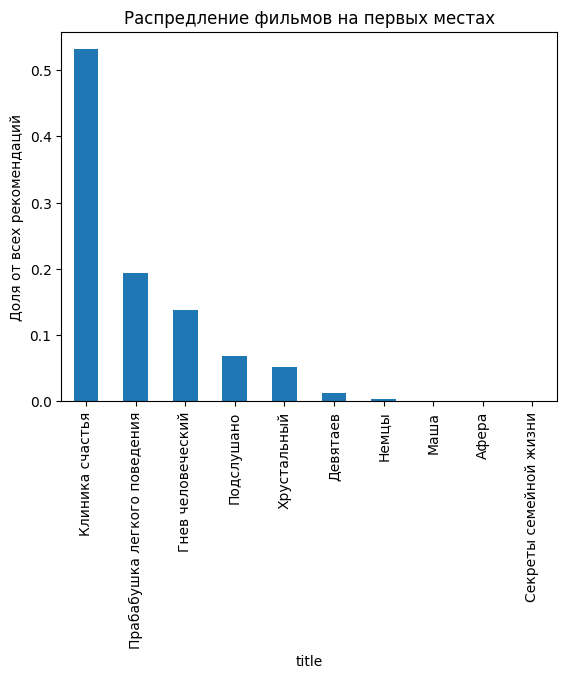

In [ ]:
first_items = pd.DataFrame([x[0] for x in test_part["als_recs"].values], columns=["item_id"])
first_items = (
    first_items.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распредление фильмов на первых местах")
plt.show()


#### Посмотрим на похожие фильмы к фильму "Гнев человеческий", согласно als

In [ ]:
items_df[items_df["title"] == 'Гнев человеческий']


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
4809,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",NaN,18.0,NaN,Гай Ричи,"Джейсон Стэйтем, Холт МакКэллани, Джеффри Доно...",Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер..."


In [ ]:
def get_similar_films(title, N=10):
    item_id = items_df[items_df["title"] == title]['item_id'].values[0]

    similar_encoded_ids = als_rec.model.similar_items(
        als_rec.item_encoder.transform([item_id]), N=N, filter_items=als_rec.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = als_rec.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["item_id"].isin(similar_ids)]["title"]


In [ ]:
get_similar_films("Гнев человеческий")

1120            Мертвые не умирают
3710                 Голос мастера
4070                        Тренер
4509                  Юность Петра
6013             Отстреливая собак
6284     Вселенная Стивена Хокинга
6589            Алиса в Зазеркалье
10036         Убийство на Мидл Бич
10293                  Потрепанные
10338                     Всё могу
Name: title, dtype: object

#### Получается, что "Гнев человеческий" и "Алиса в Зазеркалье" довольно близки.... возможно, возможно

# Данные для валидации

для начала мне хотелось выделить данные для валидации, чтобы проверять свои модели

основные вопросы, на которые мне не хватало ответов касались того, каким образом был сформирован `ground_truth` в тестовых данных:
- это просто рекоммендации от платформы кион?
- это фильмы, по которым пользователи кликнули и совершали какое-то действие с фильмом?
- это фильмы, которые эти пользователи посмотрели?
- если это фильмы, которые пользователи посмотрели, посмотрели ли они их доконца? ведь если они открыли и через 10 минут его закрыли, значит что-то пошло не так
- за какой промежуток собран `ground_truth`? это рекоммендации за один день, месяц или неделю?

все эти вопросы влияют на формирование валидации и дальнешее обучении моделей

в документации датасета от команды кион авторы написали, что их тест - это фильмы, которые пользователи посмотрели на следующей недели, после последней доступной в трейновых данных, поэтому чтобы не гадать, я предположу то же самое для текущих тестовых данных

In [ ]:
train_part

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
1224555,207142,15297,2021-07-19,24915.0,88.0
1224556,63645,16373,2021-04-20,30964.0,100.0
1224557,90242,15739,2021-07-27,12265.0,100.0
1224558,32937,10954,2021-05-13,71.0,1.0


In [ ]:
dates = train_part.last_watch_dt.unique()
dates.sort()

In [ ]:
len(dates)

141

In [ ]:
print('колво недель ', len(dates) / 7)
print('колво месяцев ', len(dates) / 30)

колво недель  20.142857142857142
колво месяцев  4.7


In [ ]:
dates[-7:]

array(['2021-07-25T00:00:00.000000000', '2021-07-26T00:00:00.000000000',
       '2021-07-27T00:00:00.000000000', '2021-07-28T00:00:00.000000000',
       '2021-07-29T00:00:00.000000000', '2021-07-30T00:00:00.000000000',
       '2021-07-31T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
k=7
train_data = train_part.loc[train_part['last_watch_dt'].isin(dates[:-k])]
val_data = train_part.loc[train_part['last_watch_dt'].isin(dates[-k:])]

In [ ]:
print("колво пользователей в тесте", len(test_part))

колво пользователей в тесте 18693


In [ ]:
val_recs = val_data.loc[val_data['watched_pct'] > 30].groupby('user_id')['item_id'].apply(list).reset_index(name='ground_truth')
val_recs['len'] = val_recs['ground_truth'].apply(lambda x: len(x))
print('среднее колво просморенных на 30% пользователями фильмов', np.mean(val_recs['len']))
print('кол-во пользователей', len(val_recs))

среднее колво просморенных на 30% пользователями фильмов 1.3344420107622834
кол-во пользователей 36981


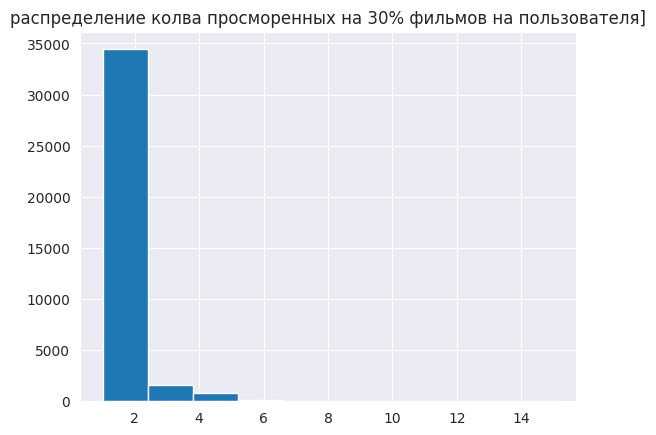

In [ ]:
plt.hist(val_recs['len'])
plt.title('распределение колва просморенных на 30% фильмов на пользователя]')
plt.show()

In [ ]:
val_recs['len'].value_counts()

1     29058
2      5374
3      1568
4       537
5       234
6        93
7        50
8        29
9        21
10        8
12        4
11        2
15        1
14        1
13        1
Name: len, dtype: int64

In [ ]:
test_part['len'] = test_part['ground_truth'].apply(lambda x: len(x))
print('среднее колво просмотренных фильмов на пользователя в тесте', np.mean(test_part['len']))

среднее колво просмотренных фильмов на пользователя в тесте 4.907879955063393


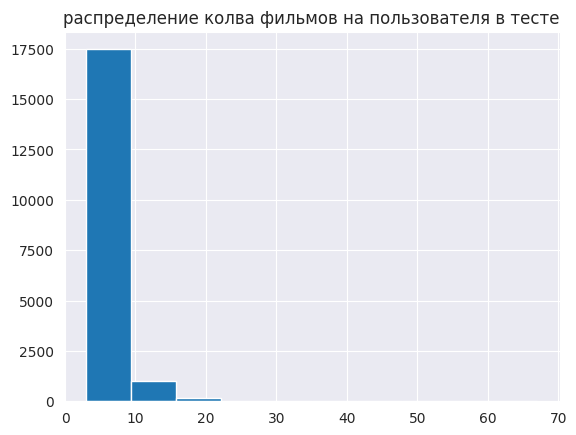

In [ ]:
plt.hist(test_part['len'])
plt.title('распределение колва фильмов на пользователя в тесте')
plt.show()

In [ ]:
test_part['len'].value_counts()

3     7630
4     4009
5     2356
6     1476
7      923
8      637
9      435
10     313
11     221
12     164
13     117
14      96
15      78
16      44
17      38
18      27
19      24
21      17
22      17
20      11
23      10
24       7
25       4
40       4
29       4
26       4
34       3
27       3
28       2
41       2
31       2
38       2
56       2
36       1
46       1
67       1
39       1
30       1
43       1
35       1
33       1
32       1
42       1
50       1
Name: len, dtype: int64

In [ ]:
len(val_recs), len(test_part)

(36981, 18693)

данные мягко говоря не соотносятся, в тесте собраные какие-то супер киноманы которые успевают за неделю посмотреть 5 фильмов. покажите мне таких людей, которые работают и учатся 24/7...  из-за такой несостыковки будет проблематично считать метрики
при этом сильно расширять валидацию не хочется, чтобы обучаться на более новых данных

я все-таки позволю себе сделать валидацию максимально похожей по структуре на тест, так как в реальной жизни я бы смогла по своим правилам разделить данные на трейн, валидацию и тест для подсчета оффлайн метрик

In [ ]:
val_recs = val_data[val_data['watched_pct'] > 0].groupby('user_id')['item_id'].apply(list).reset_index(name='ground_truth')
val_recs['len'] = val_recs['ground_truth'].apply(lambda x: len(x))
val_recs = val_recs.loc[val_recs['len'] >= 3]
print('среднее открытых пользователями фильмов', np.mean(val_recs['len']))
print('кол-во пользователей', len(val_recs))

среднее открытых пользователями фильмов 3.9551812302601896
кол-во пользователей 6649


In [ ]:
val_recs['len'].value_counts()

3     3726
4     1483
5      647
6      345
7      177
8      110
9       60
10      32
11      22
12      16
13      13
15       6
14       5
17       4
24       1
16       1
33       1
Name: len, dtype: int64

валидация не идеальна, но в целом, не вижу ничего сильно ужасного, что в ней меньше пользователей и средняя длина чут меньше. и я решила рассматривать только те фильмы, которые пользователи посмотрели хотя бы чуть чуть

# EDA

### items df

In [ ]:
train_data

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250.0,72.0
1,699317,1659,2021-05-29,8317.0,100.0
2,656683,7107,2021-05-09,10.0,0.0
3,864613,7638,2021-07-05,14483.0,100.0
4,964868,9506,2021-04-30,6725.0,100.0
...,...,...,...,...,...
1224554,160336,15171,2021-07-17,17.0,0.0
1224555,207142,15297,2021-07-19,24915.0,88.0
1224556,63645,16373,2021-04-20,30964.0,100.0
1224558,32937,10954,2021-05-13,71.0,1.0


In [ ]:
items_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12067 entries, 0 to 12066
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   item_id       12067 non-null  int64  
 1   content_type  12067 non-null  object 
 2   title         12067 non-null  object 
 3   title_orig    9144 non-null   object 
 4   release_year  12019 non-null  float64
 5   genres        12067 non-null  object 
 6   countries     12051 non-null  object 
 7   for_kids      528 non-null    float64
 8   age_rating    12066 non-null  float64
 9   studios       749 non-null    object 
 10  directors     11160 non-null  object 
 11  actors        10268 non-null  object 
 12  description   12066 non-null  object 
 13  keywords      11705 non-null  object 
dtypes: float64(3), int64(1), object(10)
memory usage: 1.3+ MB


посмотрим какая ситуация с пустыми значениями

In [ ]:
items_df.isna().sum()

item_id             0
content_type        0
title               0
title_orig       2923
release_year       48
genres              0
countries          16
for_kids        11539
age_rating          1
studios         11318
directors         907
actors           1799
description         1
keywords          362
dtype: int64

In [ ]:
items_df.loc[items_df['release_year'].isna()].head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
439,11532,series,Йога старт,NaN,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Программа от Motify подойдет для любого уровня...,"Йога, 2020, Россия, спорт-фитнес, спорт-тренер..."
1141,7724,series,Йогатерапия для спины,NaN,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Комплекс от Motify предназначен для всех без о...,"Йогатерапия, для, спины, 2021, Россия, спорт-ф..."
1225,5214,film,Юнайтед Сити - Тэгу,NaN,NaN,футбол,Россия,NaN,0.0,NaN,NaN,NaN,Лига чемпионов AFC - это главный клубный футбо...,"Юнайтед, Сити, -, Тэгу, Россия, спорт-фитнес, ..."
1488,16014,series,Работа с телом для молодости лица,NaN,NaN,"фитнес, спорт",NaN,NaN,6.0,NaN,NaN,NaN,Программа от Motify направлена на работу с тел...,"Работа, телом, для, молодости, лица"
1567,3910,series,Двойная сушка,NaN,NaN,фитнес,Россия,NaN,6.0,NaN,NaN,NaN,Общеукрепляющий комплекс от Motify на все груп...,"Двойная, сушка, Россия, спорт-фитнес, спорт-тр..."


In [ ]:
print('колво айтемов у которых нет даты выпуска', len(items_df.loc[items_df['release_year'].isna()]))
print('колво айтемов категории фитнес у которых нет даты выпуска', len(items_df.loc[(items_df['release_year'].isna()) & (items_df['genres'] == 'фитнес')]))
print('колво айтемов категории фитнес', len(items_df.loc[items_df['genres'] == 'фитнес']))


колво айтемов у которых нет даты выпуска 48
колво айтемов категории фитнес у которых нет даты выпуска 27
колво айтемов категории фитнес 165


посмотрим на признак `for kids`

In [ ]:
items_df['for_kids'].value_counts()

0.0    422
1.0    106
Name: for_kids, dtype: int64

In [ ]:
items_df.loc[items_df['for_kids'] == 1]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
303,7752,series,Приключения Паровозика Шонни,NaN,2019.0,"развлекательные, мультфильмы",Россия,1.0,0.0,NaN,NaN,NaN,Познавательный мультфильм для малышей. Паровоз...,"Приключения, Паровозика, Шонни, 2019, Россия"
447,1698,series,Бумажки,NaN,2015.0,"развлекательные, развитие, мультфильмы",Россия,1.0,0.0,NaN,"Владислав Байрамгулов, Алексей Миронов, Артур ...",Андрей Рожков,Необычный развивающий анимационный сериал для ...,"Бумажки, 2015, Россия"
721,5767,series,Найди скрытые объекты,NaN,2018.0,"развлекательные, развитие, мультфильмы",Россия,1.0,0.0,NaN,Артур Меркулов,NaN,Тренировать свою память и внимательность — пол...,"Найди, скрытые, объекты, 2018, Россия"
778,4462,film,Диномама,NaN,2013.0,"развлекательные, мультфильмы",Россия,1.0,0.0,NaN,"Джон Кафка, Чхве Юн-сок","Елена Шульман, Людмила Ильина, Ольга Голованова",Мальчик Эрни вместе со своей сестрой Джулией и...,"Диномама, 2013, Россия"
864,14979,series,Смешарики: Пин-код,NaN,2012.0,"развлекательные, развитие, мультфильмы",Россия,1.0,6.0,NaN,"Светлана Мардаголимова, Александра Аверьянова,...","Антон Виноградов, Сергей Мардарь, Михаил Черня...",Увлекательный научно-познавательный сериал обо...,"Смешарики, Пин-код, 2012, Россия"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11378,7279,series,Синий трактор на детской площадке,NaN,2019.0,"развлекательные, развитие, мультфильмы",Россия,1.0,0.0,NaN,Артур Днепровский,NaN,Кто здесь скучает? Точно не они! Синий трактор...,"Синий, трактор, детской, площадке, 2019, Россия"
11469,7935,series,Машины одёжки,NaN,2015.0,"развлекательные, мультфильмы",Россия,1.0,0.0,NaN,Дмитрий Горбунов,NaN,"Три подружки — Маша, Катя и Лиза — собираются ...","Машины, одёжки, 2015, Россия"
11568,3048,film,Плюшевый монстр,Lino: Uma Aventura de Sete Vidas,2018.0,"семейное, развлекательные, мультфильмы",Россия,1.0,6.0,NaN,Рафаэль Рибас,"Алексей Воробьёв, Елена Темникова, Полина Макс...",Мама учила Лео не сдаваться и с улыбкой приним...,"Плюшевый, монстр, 2018, Россия"
11621,2166,film,Воробьишка-хвастунишка,NaN,1981.0,"развлекательные, мультфильмы",Россия,1.0,0.0,NaN,Акмаль Акбарходжаев,Румиль Вильданов,Советский мультфильм по мотивам сказки Василия...,"Воробьишка-хвастунишка, 1981, Россия"


In [ ]:
items_df.loc[items_df['for_kids'] == 0]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
57,10871,film,Женёк,NaN,2017.0,драмы,Россия,0.0,12.0,NaN,Раушания Рахимова,"Сергей Шнырев, Ника Здорик, Евгений Попович, К...",15-летняя Женя видит себя взрослой и самостоят...,"Женёк, 2017, Россия"
79,1575,series,Охотники за искусством,Allmen,2017.0,"криминал, детективы",Россия,0.0,18.0,NaN,Томас Бергер,"Хайно Ферх, Самуэль Финци, Андреа Ошварт, Изаб...",Дерзкие ограбления и роскошные интерьеры в зах...,"Охотники, за, искусством, 2017, Россия"
80,13884,series,Супер Айза,NaN,2020.0,ток-шоу,Россия,0.0,16.0,NaN,NaN,Айза Долматова,35-летняя Айза Анохина — одна из самых противо...,"Супер, Айза, 2020, Россия"
143,5592,film,На дальних рубежах,NaN,2021.0,драмы,Россия,0.0,18.0,NaN,Максим Дашкин,"Виктория Толстоганова, Сергей Шнырев, Александ...",Мария — жена заместителя командира военной баз...,"дальних, рубежах, 2021, Россия"
159,7391,series,Игрушки,NaN,2010.0,комедии,Россия,0.0,16.0,NaN,"Роман Фокин, Ирина Васильева","Екатерина Копанова, Всеволод Болдин, Роман Пол...",Варя живёт в Москве в купленной родителями ква...,"Игрушки, 2010, Россия"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12051,3060,film,Кире,NaN,2019.0,комедии,Россия,0.0,12.0,NaN,"Рустам Рашитов, Ильсеяр Дамаскин","Камиль Ларин, Фанис Зиганшин, Гузель Сибгатулл...","Столичный риэлтор приезжает в Татарстан, чтоб ...","Кире, 2019, Россия"
12063,2367,series,Надежда,NaN,2020.0,"драмы, боевики",Россия,0.0,18.0,NaN,Елена Хазанова,"Виктория Исакова, Александр Кузьмин, Алексей М...",Оригинальный киносериал от создателей «Бывших»...,"Надежда, 2020, Россия"
12064,10632,series,Сговор,Hassel,2017.0,"драмы, триллеры, криминал",Россия,0.0,18.0,NaN,"Эшреф Рейбрук, Амир Камдин, Эрик Эгер","Ола Рапас, Алиетт Офейм, Уильма Лиден, Шанти Р...",Криминальная драма по мотивам романов о шведск...,"Сговор, 2017, Россия"
12065,4538,series,Среди камней,Darklands,2019.0,"драмы, спорт, криминал",Россия,0.0,18.0,NaN,"Марк О’Коннор, Конор МакМахон","Дэйн Уайт О’Хара, Томас Кэйн-Бирн, Джудит Родд...",Семнадцатилетний Дэмиен мечтает вырваться за п...,"Среди, камней, 2019, Россия"


есть идея, что для нанов можно выставить значение, основываясь на `age_rating` и `genres`

In [ ]:
for_kids = items_df.loc[items_df['for_kids'] == 1]
not_for_kids = items_df.loc[items_df['for_kids'] == 0]

In [ ]:
print('age rating для детей')
print(for_kids['age_rating'].value_counts())

age rating для детей
0.0     79
6.0     26
12.0     1
Name: age_rating, dtype: int64


In [ ]:
print('age rating не для детей')
print(not_for_kids['age_rating'].value_counts())

age rating не для детей
16.0    199
18.0    128
12.0     81
6.0      13
0.0       1
Name: age_rating, dtype: int64


In [ ]:
for_kids['genres'].unique()

array(['развлекательные, мультфильмы',
       'развлекательные, развитие, мультфильмы', 'развитие, мультфильмы',
       'музыка, развлекательные, мультфильмы',
       'семейное, мультфильмы, приключения, комедии',
       'музыка, развитие, мультфильмы',
       'музыка, развлекательные, для детей',
       'развлекательные, для детей, документальное',
       'музыка, развлекательные, развитие, мультфильмы',
       'развлекательные, для детей, мультфильмы',
       'семейное, развлекательные, мультфильмы',
       'развлекательные, развитие, для детей, мультфильмы',
       'семейное, для детей, фэнтези',
       'развлекательные, развитие, для детей', 'документальное',
       'музыка, мультфильмы',
       'музыка, развлекательные, для детей, музыкальные'], dtype=object)

In [ ]:
not_for_kids['genres'].unique()

array(['драмы', 'криминал, детективы', 'ток-шоу', 'комедии',
       'спорт, документальное', 'драмы, мелодрамы', 'семейное, комедии',
       'драмы, триллеры, криминал', 'музыкальные', 'документальное',
       'мультфильмы', 'драмы, комедии', 'детективы', 'драмы, криминал',
       'драмы, триллеры, детективы', 'семейное, приключения', 'триллеры',
       'молодежные, комедии', 'мелодрамы',
       'драмы, исторические, биография', 'драмы, триллеры, мелодрамы',
       'приключения, мелодрамы', 'юмор, семейное, комедии',
       'драмы, приключения', 'драмы, мистика, детективы',
       'драмы, боевики', 'драмы, биография', 'семейное',
       'исторические, военные, детективы', 'детективы, мелодрамы',
       'драмы, исторические, боевики', 'мелодрамы, комедии',
       'драмы, триллеры', 'драмы, военные',
       'исторические, документальное', 'боевики, ужасы, приключения',
       'драмы, криминал, мелодрамы',
       'приключения, драмы, триллеры, мелодрамы, комедии',
       'драмы, криминал,

In [ ]:
len(for_kids), len(for_kids.loc[for_kids['genres'].str.contains('мультфильмы')])

(106, 100)

In [ ]:
len(not_for_kids), len(not_for_kids.loc[not_for_kids['genres'].str.contains('мультфильмы')])

(422, 2)

In [ ]:
not_for_kids.loc[not_for_kids['genres'].str.contains('мультфильмы')]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
775,9584,film,"Нос, или Заговор «не таких»",NaN,2020.0,мультфильмы,Россия,0.0,16.0,NaN,Андрей Хржановский,NaN,"Авангардная, сновидческая работа Андрея Хржано...","Нос, или, Заговор, не, таких, 2020, Россия"
7027,70,series,Мульт «Кухня»,NaN,2017.0,"мультфильмы, комедии",Россия,0.0,12.0,NaN,"Дмитрий Обризан, Валерия Малкова, Вячеслав Лев...","Дмитрий Назаров, Марк Богатырев, Дмитрий Нагие...","Знакомые герои сериала «Кухня», но теперь в на...","Мульт, Кухня, 2017, Россия"


In [ ]:
items_df.loc[items_df['genres'].str.contains('для детей'), 'age_rating'].value_counts()

0.0     307
6.0     165
12.0     49
16.0      1
Name: age_rating, dtype: int64

In [ ]:
items_df.loc[(items_df['genres'].str.contains('для детей')) & (items_df['age_rating'] == 16)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
11922,6502,film,Робосапиен: Перезагрузка,Robosapien: Rebooted,2013.0,"фильмы, для детей, приключения, драмы, зарубеж...",США,NaN,16.0,NaN,Шон МакНамара,"Бадди Льюис, Билли Слотер, Бобби Коулмэн, Джей...",Талантливый добрый ученый разрабатывает робото...,"Робосапиен, Перезагрузка, 2013, США, борьба, с..."


думаю все-таки 16+ не стоит включать в категорию "для детей"

In [ ]:
cond = ((items_df['for_kids'].isna()) & (items_df['genres'].str.contains('мультфильмы')) & (items_df['age_rating'] <= 12))
items_df.loc[cond, 'for_kids'] = 1

In [ ]:
cond = ((items_df['for_kids'].isna()) & (items_df['genres'].str.contains('для детей')) & (items_df['age_rating'] < 16))
items_df.loc[cond, 'for_kids'] = 1

In [ ]:
items_df['for_kids'].isna().sum()

10963

посмотрим, что еще осталось

In [ ]:
cond = ((items_df['for_kids'].isna()) & (items_df['genres'].str.contains('мультфильмы')))
items_df.loc[cond]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
9366,14409,series,БиБаБу,NaN,2017.0,"русские, сериалы, для детей, хочу всё знать, р...",Россия,NaN,NaN,NaN,NaN,NaN,В сказочное подводное царство приглашают мален...,"друзья, магия и волшебство, рыбы, моря и океан..."
11872,6967,series,Фантастические дети,NaN,2004.0,"аниме, сериалы, зарубежные, фантастика, фэнтез...",Япония,NaN,16.0,NaN,Такаси Накамура,"Дзюнко Минагава, Сихо Квараги","Вот уже 500 лет в Европе то тут, то там появля...","Фантастические, дети, 2004, Япония, друзья, ма..."


In [ ]:
# убираем наны для мультика бибабу
items_df.loc[items_df['item_id'] == 14409, 'for_kids'] = 1
items_df.loc[items_df['item_id'] == 14409, 'age_rating'] = 0

In [ ]:
cond = ((items_df['for_kids'].isna()) & (items_df['age_rating'] <= 12))
items_df.loc[cond, 'genres'].unique()

array(['русские, мелодрамы',
       'русские, сказки, фильмы-спектакли, мюзиклы, семейное',
       'мелодрамы, зарубежные, криминал, комедии', ...,
       'приключения, советские, криминал, детективы',
       'аниме, детективы, драмы, триллеры, мелодрамы, фэнтези, комедии',
       'фэнтези, семейное, криминал, комедии'], dtype=object)

проверим еще жанр "семейное"

In [ ]:
cond = ((items_df['for_kids'].isna()) & (items_df['genres'].str.contains('семейное')) & (items_df['age_rating'] <= 12))
items_df.loc[cond, 'genres'].unique()

array(['русские, сказки, фильмы-спектакли, мюзиклы, семейное',
       'семейное, комедии', 'мелодрамы, семейное, комедии',
       'приключения, зарубежные, фантастика, боевики, семейное, комедии',
       'мультфильм, приключения, фантастика, семейное, фэнтези',
       'фильмы, приключения, советские, фантастика, семейное, комедии',
       'семейное, приключения, документальное',
       'приключения, драмы, зарубежные, боевики, семейное, комедии',
       'приключения, драмы, семейное, фэнтези, комедии', 'семейное',
       'семейное, военные, приключения, мелодрамы',
       'семейное, русские, фильмы, комедии',
       'приключения, зарубежные, мюзиклы, семейное, фэнтези, комедии',
       'семейное, русские, документальное',
       'драмы, зарубежные, семейное, мелодрамы',
       'семейное, фэнтези, приключения',
       'драмы, семейное, приключения, мелодрамы',
       'зарубежные, семейное, фэнтези, приключения',
       'семейное, русские, познавательные',
       'боевики, мелодрамы, сем

кажется это не такой очевидный фильтр, как предыдущие, поэтому пока не будем его применять

In [ ]:
cond = ((items_df['for_kids'].isna()) & ~((items_df['genres'].str.contains('семейное')) & (items_df['age_rating'] <= 12)))
items_df.loc[cond, 'for_kids'] = 0

In [ ]:
items_df['for_kids'].isna().sum()

502

остальные категории с нанами особо не восставновишь без дополнительной информации, и в целом это пока не самая важная часть

In [ ]:
items_df.head()

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
0,10711,film,Поговори с ней,Hable con ella,2002.0,"драмы, зарубежные, детективы, мелодрамы",Испания,0.0,16.0,NaN,Педро Альмодовар,"Адольфо Фернандес, Ана Фернандес, Дарио Гранди...",Мелодрама легендарного Педро Альмодовара «Пого...,"Поговори, ней, 2002, Испания, друзья, любовь, ..."
1,2508,film,Голые перцы,Search Party,2014.0,"зарубежные, приключения, комедии",США,0.0,16.0,NaN,Скот Армстронг,"Адам Палли, Брайан Хаски, Дж.Б. Смув, Джейсон ...",Уморительная современная комедия на популярную...,"Голые, перцы, 2014, США, друзья, свадьбы, прео..."
2,10716,film,Тактическая сила,Tactical Force,2011.0,"криминал, зарубежные, триллеры, боевики, комедии",Канада,0.0,16.0,NaN,Адам П. Калтраро,"Адриан Холмс, Даррен Шалави, Джерри Вассерман,...",Профессиональный рестлер Стив Остин («Все или ...,"Тактическая, сила, 2011, Канада, бандиты, ганг..."
3,7868,film,45 лет,45 Years,2015.0,"драмы, зарубежные, мелодрамы",Великобритания,0.0,16.0,NaN,Эндрю Хэй,"Александра Риддлстон-Барретт, Джеральдин Джейм...","Шарлотта Рэмплинг, Том Кортни, Джеральдин Джей...","45, лет, 2015, Великобритания, брак, жизнь, лю..."
4,11114,film,Принцесса Лебедь: Пират или принцесса,"The Swan Princess: Princess Tomorrow, Pirate T...",2016.0,"для детей, сказки, полнометражные, зарубежные,...",США,1.0,6.0,Sony Pictures,Ричард Рич,"Брайан Ниссен, Гарднер Джаэс, Грант Дураззо, Д...",Анимационная сказка о непоседливой принцессе Э...,"Принцесса, Лебедь, Пират, или, принцесса, 2016..."


In [ ]:
# года, для которых присутсвует больше всего фильмов на платформе
items_df['release_year'].value_counts().keys()[:10]

Float64Index([2020.0, 2019.0, 2018.0, 2017.0, 2016.0, 2015.0, 2014.0, 2013.0,
              2012.0, 2011.0],
             dtype='float64')

In [ ]:
# колво уникальных записей стран
print(items_df['countries'].nunique())

# топ стран
print()
print(items_df['countries'].value_counts().keys()[:20])

636

Index(['США', 'Россия', 'Франция', 'СССР', 'Великобритания', 'Италия',
       'Республика Корея', 'Украина', 'Канада', 'Испания', 'Германия',
       'Швеция', 'Великобритания, США', 'Япония', 'Австралия', 'США, Канада',
       'США, Великобритания', 'Чехия', 'Китай', 'Казахстан'],
      dtype='object')


на данном этапе это не самая актуальная часть, но если надо будет явно исопльзовать в моделях признаки фильмов, надо будет попробовать закодировать one-hot векторами страны создания и жанры

### users df

In [ ]:
users_df.isna().sum()

user_id        0
age         3582
income      3349
sex         4061
kids_flg       0
dtype: int64

In [ ]:
len(users_df[(users_df['age'].isna()) | (users_df['income'].isna()) | (users_df['sex'].isna())])

4786

пока с пропусками делать ничего не будем, посмотрим дальше в зависимости от алгоритма

In [ ]:
print('статистика по возрасту пользователей')
print(users_df['age'].value_counts(normalize=True))

статистика по возрасту пользователей
age_25_34     0.290795
age_35_44     0.268685
age_45_54     0.169832
age_18_24     0.144486
age_55_64     0.075428
age_65_inf    0.050774
Name: age, dtype: float64


In [ ]:
print('статистика по доходу пользователей')
print(users_df['income'].value_counts(normalize=True))

статистика по доходу пользователей
income_20_40      0.559620
income_40_60      0.308472
income_60_90      0.087016
income_0_20       0.025553
income_90_150     0.017977
income_150_inf    0.001362
Name: income, dtype: float64


In [ ]:
print('статистика по полу')
print(users_df['sex'].value_counts(normalize=True))

статистика по полу
Ж    0.507501
М    0.492499
Name: sex, dtype: float64


In [ ]:
print('статистика по наличию детей')
print(users_df['kids_flg'].value_counts(normalize=True))

статистика по наличию детей
0    0.675428
1    0.324572
Name: kids_flg, dtype: float64


### train df

In [ ]:
train_data.isna().sum()

user_id            0
item_id            0
last_watch_dt      0
total_dur          0
watched_pct      265
dtype: int64

[]

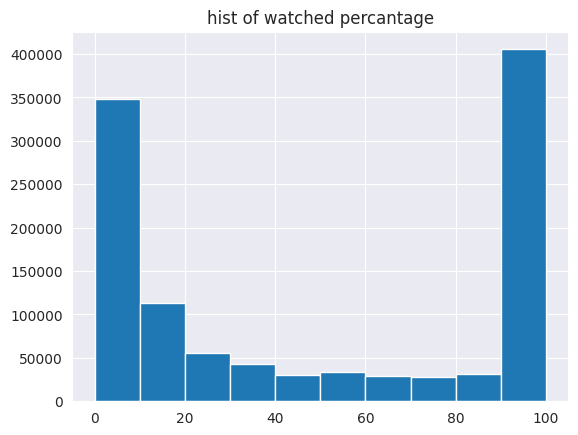

In [ ]:
plt.hist(train_data['watched_pct'])
plt.title('hist of watched percantage')
plt.plot()

In [ ]:
len(train_data[train_data['watched_pct'] == 0]) / len(train_data)

0.1286810640351089

мне интересно, правильно ли я понимаю, что если у пользователя 0% просмотра, то за просмотр это действие считать не стоит, и это типа действие "открыл карточку фильма"?..

посмотрим на фильмы и что из себя представляет топ100 по просмотрам

In [ ]:
top100movies = train_data.loc[train_data['watched_pct'] > 0, 'item_id'].value_counts().keys()[:100]
top100movies

Int64Index([15297, 10440, 13865,  9728,  4151,  3734,  2657,   142,  6809,
             4880,  4740,  8636, 11237,  1844,  7571,  9996, 12995, 14741,
            14431,  4457,  7417, 14703,  4495,  4436,   849,  7102,  5658,
            13018,  7107, 12192, 11778,  1819,  7626, 12173, 14470,   101,
             1132, 12981, 10464,  3935, 16166,  9169,  1916, 14317, 11310,
            12463,  3076,  7829, 12501,  6402, 14901, 16228,   657, 16361,
            15464,  3182,  9194,  1287, 12324, 10772,  5693, 10942,  6626,
            13915, 14359, 14461, 10077, 15531,  8447,  8373, 12770,  8618,
             1449,  5424, 11754,  1785, 11640,  5287,  5732, 12743,  4382,
             6443,  6192,  5250,  7582, 12841, 15915, 10761,  5411,  7210,
             3071, 16270,  5803, 10436,    14,    24, 13243,  1554,  6455,
             1053],
           dtype='int64')

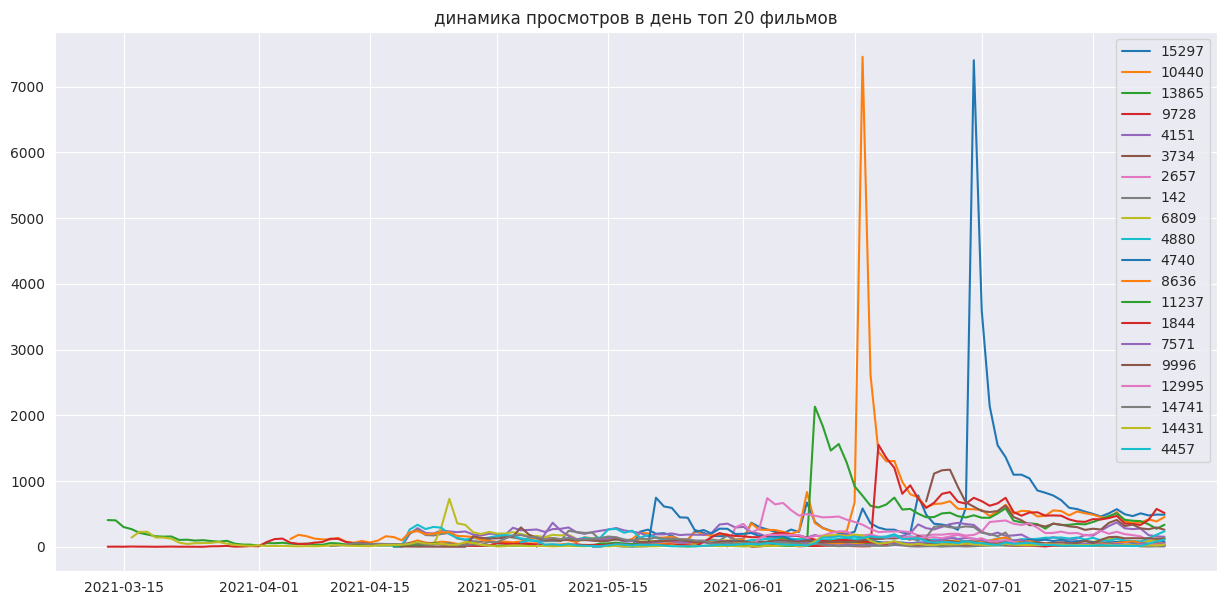

In [ ]:
k = 20
plt.figure(figsize=(15, 7))
for movie in top100movies[:k]:
    movie_watches = train_data.loc[train_data['item_id'] == movie].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
    plt.plot(movie_watches['last_watch_dt'], movie_watches['cnt'], label=str(movie))
plt.legend()
plt.title('динамика просмотров в день топ 20 фильмов')
plt.show()

вопросы:
- что это за выбросы в просмотрах и с чем это связано?
- правда ли, что в среднем пик кол-ва просмотров фильма происходит в течении пары недель после его релиза или релиза именно на платформе?

In [ ]:
items_df.loc[items_df['item_id'] == 10440]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
1429,10440,series,Хрустальный,Khrustal'nyy,2021.0,"триллеры, детективы",Россия,0.0,18.0,NaN,Душан Глигоров,"Антон Васильев, Николай Шрайбер, Екатерина Оль...",Сергей Смирнов — один из лучших «охотников на ...,"хруст, хрусталь, хруста, хрус, полицейский, пе..."


In [ ]:
movie = 10440
chrust_watches = train_data.loc[train_data['item_id'] == movie].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})

In [ ]:
chrust_watches.iloc[chrust_watches['cnt'].idxmax()]

last_watch_dt    2021-06-16 00:00:00
cnt                             7456
item_id                         7456
total_dur                       7456
watched_pct                     7456
Name: 59, dtype: object

дата пика просмотров совпадает с выходом последней серии сериала

In [ ]:
movie = 15297
items_df.loc[items_df['item_id'] == movie]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
572,15297,series,Клиника счастья,Klinika schast'ya,2021.0,"драмы, мелодрамы",Россия,0.0,18.0,NaN,Александр Кириенко,"Дарья Мороз, Анатолий Белый, Данил Акутин, Мар...","Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча..."


In [ ]:
happy_clinic = train_data.loc[train_data['item_id'] == movie].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
happy_clinic.iloc[happy_clinic['cnt'].idxmax()]

last_watch_dt    2021-06-30 00:00:00
cnt                             7403
item_id                         7403
total_dur                       7403
watched_pct                     7403
Name: 43, dtype: object

тоже самое - пик просмотров в последний день

In [ ]:
movie = 13865
items_df.loc[items_df['item_id'] == movie]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
4921,13865,film,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,0.0,12.0,NaN,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...,"Девятаев, Девятаева, Девят, Девя, Девята, Девя..."


In [ ]:
devyataev = train_data.loc[train_data['item_id'] == movie].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
devyataev.iloc[devyataev['cnt'].idxmax()]

last_watch_dt    2021-06-10 00:00:00
cnt                             2133
item_id                         2133
total_dur                       2133
watched_pct                     2133
Name: 6, dtype: object

у девятаева цифровой релиз на кионе как раз 10 июня. этот кейс уже скорее относится ко второму вопросу

по первому вопросу интересно посмотреть на графики просмотров сериалов, которые вышли в 2021 году

In [ ]:
top_2021_series = items_df.loc[((items_df['content_type'] == 'series') & (items_df['release_year'] == 2021) & (items_df['item_id'].isin(top100movies))), 'item_id']

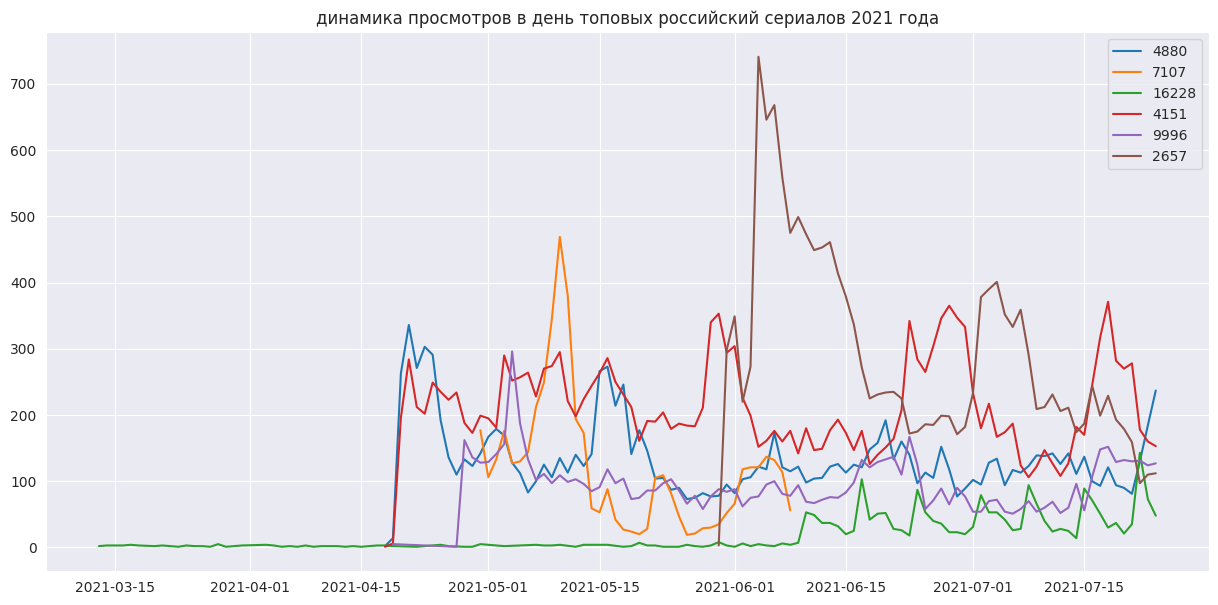

In [ ]:
k = 20
plt.figure(figsize=(15, 7))
for series in top_2021_series:
    if series == 10440 or series == 15297:
        continue    # уберем эти выбросы чтобы график легче читался
    series_watches = train_data.loc[train_data['item_id'] == series].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
    plt.plot(series_watches['last_watch_dt'], series_watches['cnt'], label=str(series))
plt.legend()
plt.title('динамика просмотров в день топовых российский сериалов 2021 года')
plt.show()

In [ ]:
item = 2657
items_df.loc[items_df['item_id'] == item]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
10305,2657,series,Подслушано,Podslushano,2021.0,"драмы, триллеры",Россия,NaN,16.0,NaN,Илья Куликов,"Александр Hовиков, Валентина Ляпина, Никита Па...",Смотри:- как кино- как сериалПодростковый псих...,"подслушано, подслушано в контакте, социальная ..."


In [ ]:
item_data = train_data.loc[train_data['item_id'] == item].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
item_data.iloc[item_data['cnt'].idxmax()]

last_watch_dt    2021-06-04 00:00:00
cnt                              741
item_id                          741
total_dur                        741
watched_pct                      741
Name: 5, dtype: object

пик в день последней серии

In [ ]:
item = 7107
items_df.loc[items_df['item_id'] == item]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
863,7107,series,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,NaN,12.0,NaN,Тимур Бекмамбетов,"Павел Прилучный, Павел Чинарёв, Тимофей Трибун...",Военно-исторический блокбастер от режиссёров Т...,NaN


In [ ]:
item_data = train_data.loc[train_data['item_id'] == item].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
item_data.iloc[item_data['cnt'].idxmax()]

last_watch_dt    2021-05-10 00:00:00
cnt                              469
item_id                          469
total_dur                        469
watched_pct                      469
Name: 10, dtype: object

нашелся интересный дубль))

In [ ]:
item = 16228
items_df.loc[items_df['item_id'] == item]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
1149,16228,series,Содержанки,NaN,2021.0,триллеры,Россия,0.0,18.0,NaN,"Константин Богомолов, Дарья Жук, Юрий Мороз","Дарья Мороз, Софья Эрнст, Сергей Бурунов, Влад...","Тонкое исследование того, как и чем живёт стол...","Содержанки, 2021, Россия"


In [ ]:
item_data = train_data.loc[train_data['item_id'] == item].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
item_data.iloc[item_data['cnt'].idxmax()]

last_watch_dt    2021-07-22 00:00:00
cnt                              143
item_id                          143
total_dur                        143
watched_pct                      143
Name: 117, dtype: object

сериал у которого в июне вышел новый сезон и видимо серии показывались по одному разу в неделю

еще посмотрим графики просмотров только для фильмов из топ100

это скорее стоит интерпретировать как колво пользователей, которые последний раз смотрели данный сериал

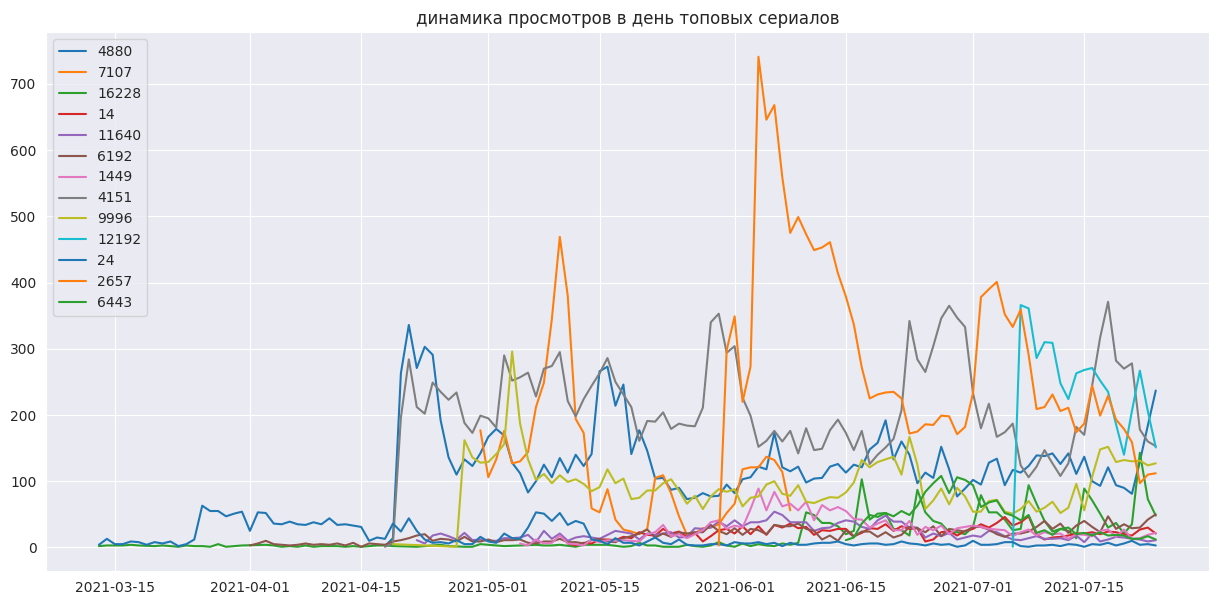

In [ ]:
top_series = items_df.loc[((items_df['content_type'] == 'series') & (items_df['item_id'].isin(top100movies))), 'item_id']
k = 20
plt.figure(figsize=(15, 7))
for series in top_series:
    if series == 10440 or series == 15297:
        continue    # уберем эти выбросы чтобы график легче читался
    series_watches = train_data.loc[train_data['item_id'] == series].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
    plt.plot(series_watches['last_watch_dt'], series_watches['cnt'], label=str(series))
plt.legend()
plt.title('динамика просмотров в день топовых сериалов')
plt.show()

можно сказать, что для сериалов, которые выходили в период сбора данных, виднеется динамика, где с выходом каждой новой серии отмечается пик просмотров, и самый большой пик приходится на финал.

для сериалов без обновления графики более плавные

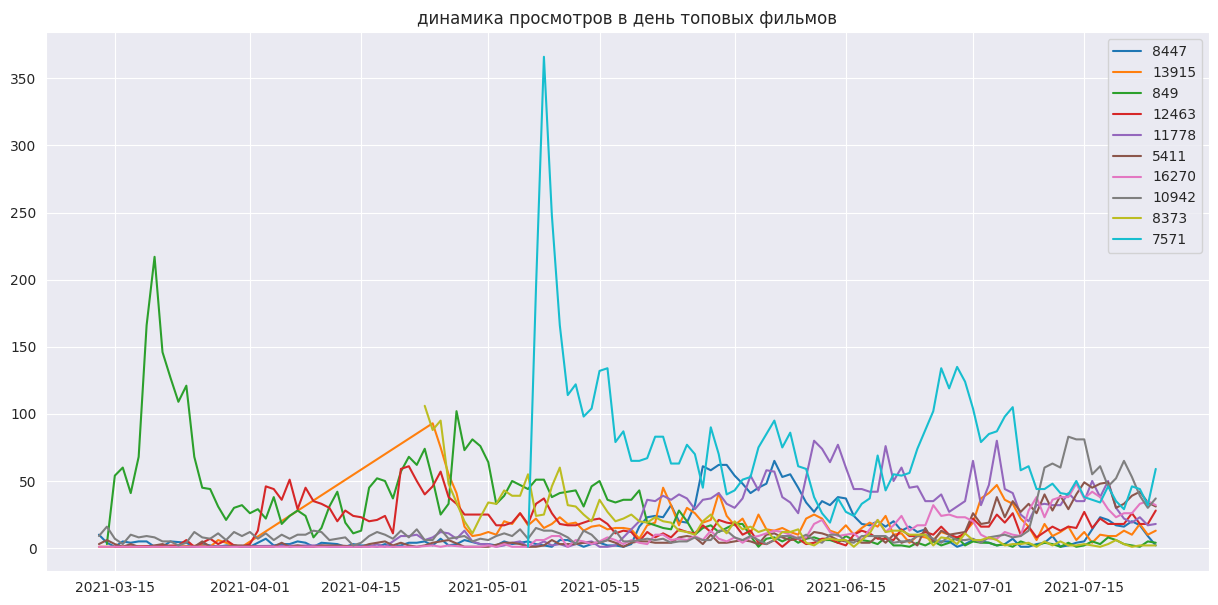

In [ ]:
top_movies = items_df.loc[((items_df['content_type'] == 'film') & (items_df['item_id'].isin(top100movies))), 'item_id']
k = 10
plt.figure(figsize=(15, 7))
for movie in top_movies[:k]:
    movies_watches = train_data.loc[train_data['item_id'] == movie].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
    plt.plot(movies_watches['last_watch_dt'], movies_watches['cnt'], label=str(movie))
plt.legend()
plt.title('динамика просмотров в день топовых фильмов')
plt.show()

In [ ]:
item = 7571
items_df.loc[items_df['item_id'] == item]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
1400,7571,film,100% волк,100% Wolf,2020.0,"мультфильм, приключения, семейное, фэнтези, ко...","Австралия, Бельгия",NaN,6.0,NaN,Алекс Стадерманн,"Илай Суинделлс, Самара Уивинг, Джай Кортни, Ру...",Наследник семьи оборотней Фредди Люпин отчаянн...,"пудель, подростковая тревога, оборотень, приня..."


In [ ]:
item_data = train_data.loc[train_data['item_id'] == item].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
item_data.iloc[item_data['cnt'].idxmax()]

last_watch_dt    2021-05-08 00:00:00
cnt                              366
item_id                          366
total_dur                        366
watched_pct                      366
Name: 2, dtype: object

резиз в россии в кино был 8 апреля, предположу что 8 мая был релиз на кионе

In [ ]:
item = 849
items_df.loc[items_df['item_id'] == item]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
211,849,film,Дебошир,The Brawler,2018.0,"историческое, биография, криминал, драмы, спор...",США,0.0,18.0,NaN,Кен Кушнер,"Зэк Макгоун, Эми Смарт, Джо Пантольяно, Тэрин ...",Легендарный боксёр Чак Вепнер (на экране его и...,"2018, соединенные штаты, дебошир"


In [ ]:
item_data = train_data.loc[train_data['item_id'] == item].groupby('last_watch_dt').count().reset_index().rename(columns={'user_id': 'cnt'})
item_data.iloc[item_data['cnt'].idxmax()]

last_watch_dt    2021-03-20 00:00:00
cnt                              217
item_id                          217
total_dur                        217
watched_pct                      217
Name: 6, dtype: object

заметно, у новых релизнутых фильмов сильно растут просмотры в первые дни. у старых фильмов все стабильно

**вывод:**
- необходимо учитывать историю количества просмотров за последние пару дней, неделю и месяц, чтобы ввести для модели какие-то знаки что сейчас происходит с фильмом/сериалом
- кажется неплохой идей добавить дату релиза фильма и выхода последней серии для сериала, но это надо дополнительно парсить информацию
- дальше надо аккуртно обработать два супер выброса

посмотрим на данные со стороны пользователей

In [ ]:
print('колво пользователй в трейне', train_data['user_id'].nunique())
print('колво пользователей для которых известны мета данные', users_df['user_id'].nunique())

колво пользователй в трейне 425949
колво пользователей для которых известны мета данные 366088


In [ ]:
cnt_items_per_user = train_data.loc[train_data['watched_pct'] > 0].groupby('user_id')['item_id'].count().sort_values(ascending=False).reset_index().rename(columns={'item_id': 'cnt_items'})

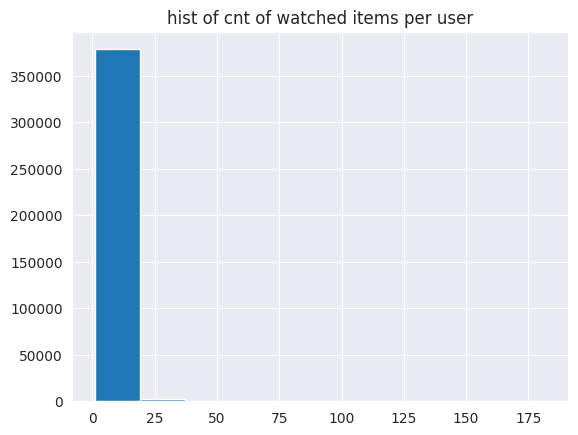

In [ ]:
plt.hist(cnt_items_per_user['cnt_items'])
plt.title('hist of cnt of watched items per user')
plt.show()

In [ ]:
cnt_items_per_user['cnt_items'].value_counts(normalize=True)

1      0.524390
2      0.193571
3      0.098481
4      0.056074
5      0.034837
         ...   
83     0.000003
82     0.000003
79     0.000003
76     0.000003
182    0.000003
Name: cnt_items, Length: 97, dtype: float64

у меня была мысль попробовать коллаборативную фильтрацию которая ищет похожих по просмотренным фильмам пользователей, но с учетом того, что больше чем у половины пользователей отмечен только один фильм, маловероятно что данный подход сможет что-то нормально предсказать

In [ ]:
# очень интересная выбивающаяся запись
cnt_items_per_user.loc[cnt_items_per_user['cnt_items'] == 182]

,user_id,cnt_items
0,11526,182


In [ ]:
weird_ppl = train_data.loc[train_data['user_id'] == 11526].sort_values('last_watch_dt')
weird_ppl

,user_id,item_id,last_watch_dt,total_dur,watched_pct
1024676,11526,14504,2021-03-15,52.0,1.0
1017858,11526,112,2021-03-22,329.0,6.0
231795,11526,2766,2021-03-22,725.0,12.0
930824,11526,6949,2021-03-23,28.0,1.0
1016529,11526,5854,2021-03-23,241.0,5.0
...,...,...,...,...,...
4695,11526,14959,2021-07-12,581.0,10.0
730719,11526,12695,2021-07-15,1763.0,24.0
1041621,11526,14826,2021-07-15,18189.0,100.0
1119195,11526,5252,2021-07-17,5430.0,100.0


(array([85., 37., 20., 12.,  6.,  5.,  4.,  1.,  3., 14.]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.]),
 <BarContainer object of 10 artists>)

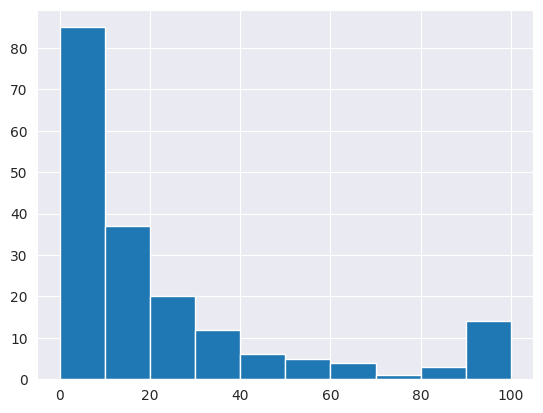

In [ ]:
plt.hist(weird_ppl['watched_pct'])

In [ ]:
items_df.loc[items_df['item_id'].isin([12695, 14826])]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,directors,actors,description,keywords
528,12695,film,Мулен Руж,Moulin Rouge,2001.0,"драмы, мюзиклы, мелодрамы","Австралия, США",0.0,16.0,NaN,Баз Лурман,"Николь Кидман, Юэн МакГрегор, Джон Легуизамо, ...",Действие фильма разворачивается в 1899 году в ...,"фея, герцог, мюзикл, писательский блок, музыка..."
704,14826,film,Толстяки,Gordos,2009.0,"драмы, комедии",Испания,0.0,18.0,NaN,Даниэль Санчес Аревало,"Антонио де ла Торре, Роберто Энрикес, Вероника...",Мы находимся в группе поддержки людей с избыто...,"толстый мужчина, полная женщина, гей-тема, 200..."


In [ ]:
users_df.loc[users_df['user_id'] == 11526]

,user_id,age,income,sex,kids_flg
346287,11526,age_25_34,income_40_60,М,0


🤔🤔🤔

мне кажется это выброс и стоит убрать записи этого человека

In [ ]:
train_data.drop(train_data.loc[train_data['user_id'] == 11526].index, inplace=True)

In [ ]:
len(train_data)

1117934

посмотрим на внимательнее на пользователей, которые смотрят фильмы

In [ ]:
users_df['income'].unique(), users_df['age'].unique()

(array(['income_60_90', 'income_20_40', 'income_40_60', 'income_90_150',
        'income_0_20', nan, 'income_150_inf'], dtype=object),
 array(['age_25_34', 'age_18_24', 'age_45_54', 'age_35_44', 'age_55_64',
        'age_65_inf', nan], dtype=object))

In [ ]:
# для удобного сбора статистики медиан и перцентилей

income_mapping = {
    'income_0_20': 0,
    'income_20_40': 1,
    'income_40_60': 2,
    'income_60_90': 3,
    'income_90_150': 4,
    'income_150_inf': 5
}

income_int_maping = dict()
for (k, v) in income_mapping.items():
    income_int_maping[v] = k

age_mapping = {
    'age_18_24': 0,
    'age_25_34': 1,
    'age_35_44': 2,
    'age_45_54': 3,
    'age_55_64': 4,
    'age_65_inf': 5
}

age_int_maping = dict()
for (k, v) in age_mapping.items():
    age_int_maping[v] = k

users_df['income_int'] = users_df['income'].map(income_mapping)
users_df['age_int'] = users_df['age'].map(age_mapping)

In [ ]:
female_key = 'Ж'
male_key = 'М'

for item_id in tqdm(items_df['item_id'].unique()):
    users = train_data.loc[train_data['item_id'] == item_id, 'user_id'].values
    users_data = users_df.loc[users_df['user_id'].isin(users)]
    cnt_users = len(users)

    all_sex = users_data.loc[users_data['sex'].notna(), 'sex']
    cnt_users_with_sex = len(all_sex)
    if cnt_users_with_sex > 0:
        all_sex = all_sex.value_counts(normalize=True)
        if female_key in all_sex:
            female_r = all_sex[female_key]
        else:
            female_r = 0
        if male_key in all_sex:
            male_r = all_sex[male_key]
        else:
          male_r = 0
    else:
        female_r = None
        male_r = None

    all_age = users_data.loc[users_data['age'].notna(), 'age']
    if len(all_age) > 0:
        majority_age = all_age.value_counts().keys()[0]
        median_age_int = int(users_data.loc[users_data['age_int'].notna(), 'age_int'].median())
        median_age = age_int_maping[median_age_int]
    else:
        majority_age = None
        median_age = None

    all_income = users_data.loc[users_data['income'].notna(), 'income']
    if len(all_income) > 0:
        majority_income = all_income.value_counts().keys()[0]
        median_income_int = int(users_data.loc[users_data['income_int'].notna(), 'income_int'].median())
        median_income = income_int_maping[median_income_int]
    else:
        majority_income = None
        median_income = None

    new_cols = ['cnt_users', 'cnt_users_with_sex', 'female_r', 'male_r', 'age_major', 'age_median', 'income_major', 'income_median']
    new_vals = [cnt_users, cnt_users_with_sex, female_r, male_r, majority_age, median_age, majority_income, median_income]
    items_df.loc[items_df['item_id'] == item_id, new_cols] = new_vals

  0%|          | 0/12067 [00:00<?, ?it/s]

In [ ]:
items_df.isna().sum()

item_id                   0
content_type              0
title                     0
title_orig             2923
release_year             48
genres                    0
countries                16
for_kids                502
age_rating                1
studios               11318
directors               907
actors                 1799
description               1
keywords                362
cnt_users                 0
cnt_users_with_sex        0
female_r               1113
male_r                 1113
age_major              1115
age_median             1115
income_major           1110
income_median          1110
dtype: int64

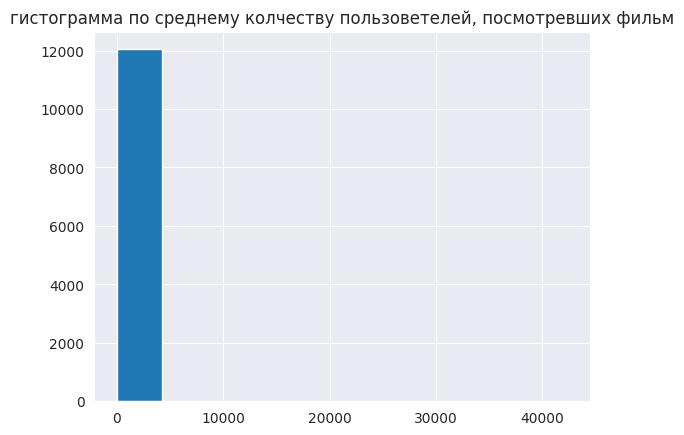

In [ ]:
plt.hist(items_df['cnt_users'])
plt.title('гистограмма по среднему колчеству пользоветелей, посмотревших фильм')
plt.show()

видим очень тяжелый хвост, не забываем что у нас еще есть пару выбросов с кучей просмотров

In [ ]:
print('средние по долям женщин и мужчин')
print(items_df[['female_r', 'male_r']].mean())

средние по долям женщин и мужчин
female_r    0.510833
male_r      0.489167
dtype: float64


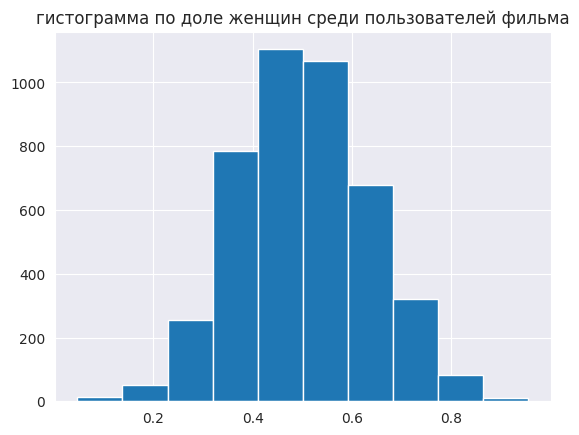

In [ ]:
plt.hist(items_df.loc[items_df['cnt_users_with_sex'] > 10, 'female_r'])
plt.title('гистограмма по доле женщин среди пользователей фильма')
plt.show()

In [ ]:
print('фильмы, которые в большинстве смотрят женщины')
items_df.loc[items_df['cnt_users_with_sex'] > 10].sort_values('female_r', ascending=False).head(10)

фильмы, которые в большинстве смотрят женщины


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,...,description,keywords,cnt_users,cnt_users_with_sex,female_r,male_r,age_major,age_median,income_major,income_median
2016,5400,series,Частица вселенной,NaN,2017.0,"драмы, мелодрамы",Россия,0.0,16.0,NaN,...,Экипаж российских и американских космонавтов г...,"Частица, вселенной, 2017, Россия",30.0,22.0,0.954545,0.045455,age_45_54,age_35_44,income_40_60,income_40_60
10830,15413,series,Тени прошлого,Teni proshlogo,2014.0,мелодрамы,Россия,0.0,12.0,NaN,...,"Для главной героини Ксении, семья была тихой г...",NaN,16.0,14.0,0.928571,0.071429,age_25_34,age_25_34,income_20_40,income_20_40
10697,5227,film,Пионеры-герои,Pionery-geroi,2015.0,драмы,Россия,0.0,16.0,NaN,...,"Ольга, Катя и Андрей давно приехали в Москву, ...","несчастье, удовлетворение, 2015, россия, пионе...",20.0,13.0,0.923077,0.076923,age_35_44,age_35_44,income_20_40,income_20_40
3760,11851,film,Карантин,Karantin,1983.0,"семейное, приключения, комедии",СССР,NaN,6.0,NaN,...,"Когда в детском саду объявили карантин, оказал...","гольфы, Гольфы, Оригинальное название из одног...",13.0,11.0,0.909091,0.090909,age_35_44,age_35_44,income_20_40,income_20_40
4651,12411,series,Чужие мечты,Chuzhie mechty,2011.0,мелодрамы,Россия,0.0,12.0,NaN,...,"Однажды в отделение травматологии, где работае...",NaN,15.0,11.0,0.909091,0.090909,age_35_44,age_35_44,income_20_40,income_20_40
6545,5237,series,Личная жизнь,Love Life,2020.0,"мелодрамы, комедии",США,0.0,18.0,NaN,...,Сериал-антология о самом главном чувстве. В пе...,"Личная, жизнь, 2020, США",13.0,11.0,0.909091,0.090909,age_25_34,age_25_34,income_20_40,income_40_60
3461,7423,film,Выбор,The Choice,2016.0,"драмы, зарубежные, мелодрамы",США,0.0,16.0,NaN,...,Закоренелый холостяк Тревис Паркер не верит в ...,"Выбор, 2016, США, любовь, смена, жизненных, пр...",19.0,17.0,0.882353,0.117647,age_25_34,age_35_44,income_20_40,income_20_40
11705,6863,film,Мой единственный,My One and Only,2009.0,"биография, приключения, драмы, мелодрамы, комедии",США,0.0,16.0,NaN,...,Гламурная Анн Деверо катит по восточному побер...,"кинобизнес, сен-луи, дорожное путешествие, 195...",17.0,16.0,0.875000,0.125000,age_45_54,age_45_54,income_20_40,income_20_40
2083,11397,series,Исчезающая,Das Verschwinden (The Vanishing),2017.0,"драмы, мистика, детективы",Россия,0.0,18.0,NaN,...,Двадцатилетняя девушка исчезает из небольшого ...,"Исчезающая, 2017, Россия",19.0,16.0,0.875000,0.125000,age_18_24,age_25_34,income_20_40,income_20_40
8086,4131,series,"Учитель Ким, доктор Романтик",Dr. Romantic,2016.0,"драмы, мелодрамы",Республика Корея,0.0,16.0,NaN,...,"Пу Ён-джу когда-то был известным хирургом, его...","сельская местность, больница, врач, романтик",70.0,55.0,0.872727,0.127273,age_25_34,age_35_44,income_20_40,income_20_40


In [ ]:
print('фильмы, которые в большинстве смотрят мужчины')
items_df.loc[items_df['cnt_users_with_sex'] > 10].sort_values('male_r', ascending=False).head(10)

фильмы, которые в большинстве смотрят мужчины


,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,...,description,keywords,cnt_users,cnt_users_with_sex,female_r,male_r,age_major,age_median,income_major,income_median
7397,5651,film,Ангелы луны (полная версия),Luna's angels (Full version),2007.0,для взрослых,Италия,0.0,21.0,NaN,...,Суперагенты-красавицы в бикини получают задани...,"2007, италия, ангелы, луны, полная, версия",36.0,21.0,0.047619,0.952381,age_25_34,age_35_44,income_40_60,income_40_60
5552,14777,film,Гибкая студентка,Stretched Coed Pink,2015.0,для взрослых,США,0.0,21.0,NaN,...,"Очаровательные девушки выбрались за город, что...","Гибкая студентка, Stretched Coed Pink, Молли М...",27.0,19.0,0.052632,0.947368,age_25_34,age_35_44,income_40_60,income_40_60
1064,5887,series,Снайпер. Офицер СМЕРШ,NaN,2018.0,"русские, военные, мелодрамы",Россия,0.0,12.0,NaN,...,В осажденном Сталинграде пересеклись пути двух...,"Снайпер, Офицер, СМЕРШ, 2018, Россия, Великая,...",14.0,13.0,0.076923,0.923077,age_25_34,age_25_34,income_40_60,income_40_60
2530,2417,film,Тарзан и его подруга,Tarzan and His Mate,1934.0,"боевики, приключения",США,0.0,12.0,NaN,...,Мартин и Гари отправляются в экспедицию за сло...,"африка, экспедиция, лев, слон, крокодил, жадно...",16.0,12.0,0.083333,0.916667,age_55_64,age_35_44,income_40_60,income_40_60
3553,400,film,Праздник Клаудии (полная версия),Claudia's holiday (Full version),2006.0,для взрослых,Италия,0.0,21.0,NaN,...,"Ибица – место для жарких вечеринок, курортных ...","2006, италия, праздник, клаудии, полная, версия",14.0,11.0,0.090909,0.909091,age_25_34,age_25_34,income_40_60,income_40_60
421,8278,film,Искусство соблазнения,The art of seduction,2019.0,для взрослых,США,0.0,21.0,NaN,...,Опытные красотки знают всё об искусстве соблаз...,"2019, соединенные штаты, искусство, соблазнения",28.0,19.0,0.105263,0.894737,age_25_34,age_25_34,income_20_40,income_40_60
11079,10808,series,Воин,Warrior,2019.0,"боевики, исторические",США,0.0,18.0,Cinemax,...,"Экшен-сериал, созданный шоураннером проекта «Б...","Воин, 2019, США",22.0,17.0,0.117647,0.882353,age_25_34,age_25_34,income_20_40,income_20_40
8173,12327,film,Любители ног,Foot Lovers,2018.0,для взрослых,Чехия,0.0,21.0,NaN,...,Ноги – это одна из самых сексуальных частей те...,"2018, чехия, любители, ног",25.0,17.0,0.117647,0.882353,age_45_54,age_35_44,income_20_40,income_20_40
10096,252,film,[4k] Стартрек: Возмездие,Star Trek: Into Darkness,2013.0,"боевики, зарубежные, фантастика, приключения",США,0.0,12.0,Paramount,...,Смотрите в 4К! Перезагрузка легендарной франши...,"4k, Стартрек, Возмездие, 2013, США, космос, ра...",22.0,17.0,0.117647,0.882353,age_25_34,age_25_34,income_20_40,income_20_40
6208,13625,film,История игрушек: Мальчики не включены,Toy Stories: Boys Not Included,2011.0,для взрослых,Великобритания,0.0,21.0,NaN,...,"Эти девчонки научились классно развлекаться, и...","История игрушек: Мальчики не включены, Toy Sto...",25.0,17.0,0.117647,0.882353,age_35_44,age_35_44,income_20_40,income_20_40


In [ ]:
items_df['age_major'].value_counts(normalize=True)

age_25_34     0.367695
age_35_44     0.324233
age_45_54     0.135683
age_18_24     0.099160
age_55_64     0.041271
age_65_inf    0.031958
Name: age_major, dtype: float64

In [ ]:
items_df['income_major'].value_counts(normalize=True)

income_20_40      0.683855
income_40_60      0.225153
income_60_90      0.055672
income_90_150     0.022360
income_0_20       0.011408
income_150_inf    0.001552
Name: income_major, dtype: float64

# Обучение

### ALS

In [ ]:
users = train_data['user_id'].unique()
users.sort()
len(users), users

(425948, array([      0,       2,       3, ..., 1097550, 1097554, 1097555]))

для начала попробуем подход ALS. я решила оставить исходные параметры, так как мне кажется что колво итераций = 1 и колво латентных факторов 100 маловато

In [ ]:
als_base = ALS()
als_base.fit(train_data)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
print('кол-во пользователей, которых нет в тренировочном датасете')
print(len(np.setdiff1d(val_recs['user_id'].values, train_data['user_id'].unique())))

кол-во пользователей, которых нет в тренировочном датасете
2140


сейчас для оценки чисто работы модели ALS, можно посчитать метрики без учета этих пользователей. далее можно придумать для них эвристики - советовать популярные или находить похожих пользователей (например по возрасту, полу и доходу) и советовать что-то их из просмотров

In [ ]:
train_users = np.intersect1d(train_data['user_id'].unique(), val_recs['user_id'].values)
print(len(train_users))

4509


In [ ]:
recs = als_base.predict(val_recs[val_recs['user_id'].isin(train_users)])

predicting:   0%|          | 0/4509 [00:00<?, ?it/s]

In [ ]:
val_recs_train = val_recs.loc[val_recs['user_id'].isin(train_users)].copy()
val_recs_train['als_base_recs'] = recs
print('val score:', evaluate_recommender(val_recs_train, model_preds_col="als_base_recs"))

val score: {'ndcg': 0.04335098304662682, 'recall': 0.01852089718024515}


In [ ]:
train_test_users = np.intersect1d(train_data['user_id'].unique(), test_part['user_id'].values)
test_recs = als_base.predict(test_part[test_part['user_id'].isin(train_test_users)], to_filter=val_recs)
test_recs_train = test_part.loc[test_part['user_id'].isin(train_test_users)].copy()
test_recs_train['als_base_recs'] = test_recs
print('test score:', evaluate_recommender(test_recs_train, model_preds_col="als_base_recs"))

predicting:   0%|          | 0/15474 [00:00<?, ?it/s]

test score: {'ndcg': 0.04630831459127934, 'recall': 0.017435196357614636}


попробуем понять, что не так. во-первых есть предположение, что за последнюю неделю, которая перешла в валидацию, потерялось много данных для трейна. поэтому попробуем обучить такую же модель, но на всем тренировочном датасете

In [ ]:
als_base_big = ALS()
als_base_big.fit(train_part)
test_part["als_base_rect"] = als_base_big.predict(test_part)
print('als base big model, test score:', evaluate_recommender(test_part, model_preds_col="als_base_rect"))


  0%|          | 0/5 [00:00<?, ?it/s]

predicting:   0%|          | 0/18693 [00:00<?, ?it/s]

als base big model, test score: {'ndcg': 0.05319202875148974, 'recall': 0.020605472501701437}


улучшение есть, но все равно есть подозрение что дело не только в данных

дальше у меня был вопрос, появляются ли в рекоммендациях фильмы, которые уже были просмотрены пользователем? в документации imlicit есть парметр для такой опции, и у нас он выставлен

In [ ]:
users_and_cnts = train_data[train_data['user_id'].isin(train_users)].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id':'cnt_items'})
users_and_cnts[users_and_cnts['cnt_items'] > 10]

,user_id,cnt_items
1,858,16
6,1823,26
8,2099,12
11,2676,20
24,5915,14
...,...,...
4500,1095381,20
4501,1095385,13
4506,1096947,12
4507,1097060,36


посмотрим юзера 5915

In [ ]:
user = 5915
users_df.loc[users_df['user_id'] == user]

,user_id,age,income,sex,kids_flg,income_int,age_int
12194,5915,age_35_44,income_20_40,М,0,1.0,2.0


In [ ]:
train_data.loc[train_data['user_id'] == user].sort_values('last_watch_dt')

,user_id,item_id,last_watch_dt,total_dur,watched_pct
754171,5915,12299,2021-03-17,4116.0,51.0
725231,5915,8636,2021-04-16,14504.0,100.0
333910,5915,15715,2021-04-18,6732.0,90.0
593126,5915,2237,2021-04-18,8451.0,100.0
655490,5915,945,2021-04-21,10179.0,100.0
774478,5915,4024,2021-04-26,7475.0,100.0
730924,5915,2696,2021-05-30,7985.0,100.0
1043682,5915,1819,2021-05-31,8166.0,100.0
433104,5915,7807,2021-06-16,777.0,15.0
633459,5915,147,2021-06-22,7470.0,100.0


In [ ]:
movies = train_data.loc[train_data['user_id'] == user].sort_values('last_watch_dt')['item_id']
items_df.loc[items_df['item_id'].isin(movies)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,...,description,keywords,cnt_users,cnt_users_with_sex,female_r,male_r,age_major,age_median,income_major,income_median
547,2696,film,Восточный ветер 2,Ostwind 2,2015.0,"драмы, семейное, приключения, мелодрамы",Германия,NaN,6.0,NaN,...,"Наступили летние каникулы, и Мика возвращается...","отношения родитель-ребенок, дедушка, внуки, ка...",81.0,72.0,0.569444,0.430556,age_25_34,age_35_44,income_20_40,income_20_40
910,7807,film,Война полов,Voyna polov,2015.0,комедии,Россия,0.0,16.0,NaN,...,Что завтра на рассвете с каждым из нас случитс...,"2015, россия, война, полов",242.0,199.0,0.417085,0.582915,age_25_34,age_35_44,income_20_40,income_20_40
964,12299,film,Новый Человек-паук: Высокое напряжение,The Amazing Spider-Man 2,2014.0,"боевики, фантастика, приключения",США,0.0,12.0,NaN,...,Питер Паркер под маской Человека-паука по-преж...,"одержимость, эксперимент, продолжение, основан...",187.0,144.0,0.423611,0.576389,age_25_34,age_25_34,income_20_40,income_20_40
1175,1743,film,Малефисента,Maleficent,2014.0,"семейное, фэнтези, приключения, мелодрамы",США,NaN,12.0,NaN,...,Юная волшебница Малефисента вела уединенную жи...,"сказка, злодей, спящая красавица, темное фэнте...",318.0,255.0,0.576471,0.423529,age_25_34,age_25_34,income_20_40,income_20_40
4248,4024,film,"Я, робот","I, Robot",2004.0,"боевики, драмы, фантастика, триллеры","США, Германия",0.0,12.0,NaN,...,В недалёком будущем детектив Спунер (Уилл Смит...,"самоубийство, искусственный интеллект, человек...",439.0,394.0,0.441624,0.558376,age_35_44,age_35_44,income_20_40,income_20_40
4447,15715,film,Шугалей 2,Shugaley 2,2020.0,"боевики, приключения",Россия,0.0,16.0,NaN,...,Российский социолог Максим Шугалей и его колле...,"тюрьма, война, переводчик, социолог, 2020, рос...",478.0,428.0,0.348131,0.651869,age_35_44,age_35_44,income_20_40,income_20_40
4578,147,film,Единичка,Edinichka,2015.0,"драмы, военные",Россия,0.0,12.0,NaN,...,Август 1944-го. Советские войска продолжают на...,"2015, россия, единичка",244.0,211.0,0.293839,0.706161,age_35_44,age_35_44,income_20_40,income_20_40
4677,945,film,"Хроники Нарнии: Лев, колдунья и волшебный шкаф","The Chronicles of Narnia: The Lion, the Witch ...",2005.0,"семейное, фэнтези, приключения","США, Великобритания",NaN,6.0,NaN,...,Четверых детей родители отправляют из Лондона ...,"спасение мира, родственные отношения, ведьма, ...",321.0,265.0,0.581132,0.418868,age_25_34,age_35_44,income_20_40,income_20_40
5678,8636,film,Белый снег,Belyy sneg,2021.0,"драмы, спорт",Россия,0.0,6.0,NaN,...,Отечественная спортивная драма про лыжницу и о...,"биография, занятие спортом, байопик, чемпионат...",8343.0,7002.0,0.488860,0.511140,age_35_44,age_35_44,income_20_40,income_20_40
6282,2954,film,Миньоны,Minions,2015.0,"фантастика, мультфильм, приключения, комедии",США,0.0,6.0,NaN,...,Миньоны живут на планете гораздо дольше нас. У...,"помощник, сцена после титров, сцена во время т...",743.0,558.0,0.491039,0.508961,age_25_34,age_35_44,income_20_40,income_20_40


In [ ]:
rec_movies = val_recs_train.loc[val_recs_train['user_id'] == user, 'als_base_recs'].values[0]
items_df.loc[items_df['item_id'].isin(rec_movies)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,...,description,keywords,cnt_users,cnt_users_with_sex,female_r,male_r,age_major,age_median,income_major,income_median
117,13915,film,Вперёд,Onward,2020.0,"для детей, приключения, семейное, фэнтези, ком...",США,1.0,6.0,NaN,...,"Когда-то давно в сказочном мире царила магия, ...","эльфы, мир фантазий, эльф, главный герой подро...",1781.0,1504.0,0.498005,0.501995,age_25_34,age_25_34,income_20_40,income_20_40
2117,12841,film,Стражи Галактики,GUARDIANS OF THE GALAXY,2014.0,"боевики, фантастика, приключения, комедии",США,0.0,12.0,NaN,...,Отважному путешественнику Питеру Квиллу попада...,"космический корабль, основанный на комиксе, ко...",1280.0,1143.0,0.405949,0.594051,age_25_34,age_35_44,income_20_40,income_20_40
3061,5754,film,Доктор Стрэндж,DOCTOR STRANGE,2016.0,"боевики, фантастика, фэнтези, приключения",США,0.0,16.0,NaN,...,Страшная автокатастрофа поставила крест на кар...,"магия, время, обучение, супергерой, по мотивам...",924.0,818.0,0.469438,0.530562,age_25_34,age_25_34,income_20_40,income_20_40
3237,5693,film,Алита: Боевой ангел,Alita: Battle Angel,2019.0,"боевики, фантастика, триллеры, приключения",США,0.0,16.0,NaN,...,Действие фильма происходит через 300 лет после...,"боевые искусства, охотник за головами, экстрем...",1788.0,1621.0,0.388032,0.611968,age_35_44,age_35_44,income_20_40,income_20_40
5605,3095,film,Тор: Царство тьмы,THOR: THE DARK WORLD,2013.0,"боевики, фэнтези, приключения",США,0.0,12.0,NaN,...,Могучему Тору предстоит вновь сразиться за вос...,"супергерой, основанный на комическом, скандина...",1184.0,1067.0,0.393627,0.606373,age_25_34,age_25_34,income_20_40,income_20_40
7590,5250,film,Золото джунглей,Oro,2017.0,"драмы, приключения",Испания,0.0,18.0,NaN,...,1538 год. Король Испании и император священной...,"Эльдорадо, 2017, испания, золото, джунглей",1326.0,1180.0,0.407627,0.592373,age_35_44,age_35_44,income_20_40,income_20_40
9077,12324,film,Патруль: По законам улиц,Shorta,2020.0,боевики,Дания,0.0,18.0,NaN,...,Полицейские Йенс и Майк регулярно патрулируют ...,"2020, дания, патруль, по, законам, улиц",1911.0,1667.0,0.348530,0.651470,age_25_34,age_35_44,income_20_40,income_20_40
10127,5424,film,Марафон желаний,Marafon zhelaniy,2020.0,"мелодрамы, комедии",Россия,0.0,16.0,NaN,...,«Я хочу нижнее белье из одного комплекта. Я хо...,"2020, россия, марафон, желаний",1523.0,1206.0,0.558872,0.441128,age_25_34,age_35_44,income_20_40,income_20_40
10584,3587,film,Железный человек,IRON MAN,2008.0,"боевики, фантастика, приключения","США, Канада",0.0,12.0,NaN,...,Миллиардер-изобретатель Тони Старк попадает в ...,"Ближний Восток, торговец оружием, Малибу, супе...",790.0,674.0,0.425816,0.574184,age_25_34,age_25_34,income_20_40,income_20_40
11498,15531,film,Секса много не бывает,Un heureux événement,2011.0,"драмы, комедии",Франция,0.0,18.0,NaN,...,Барбара и Николас знакомятся в видеомагазине. ...,"желать ребенка, Беременность, Больница, Видео-...",1643.0,1487.0,0.444519,0.555481,age_35_44,age_35_44,income_20_40,income_20_40


на первый взгляд кажется что рекоммендации довольно удачные - пользователь любит мейнстримные фентези, боевики, комедии

посмотрим что было в реальности

In [ ]:
truth_movies = val_recs_train.loc[val_recs_train['user_id'] == user, 'ground_truth'].values[0]
items_df.loc[items_df['item_id'].isin(truth_movies)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,...,description,keywords,cnt_users,cnt_users_with_sex,female_r,male_r,age_major,age_median,income_major,income_median
3067,8386,film,Валериан и город тысячи планет,Valerian and the City of a Thousand Planets,2017.0,"боевики, фантастика, фэнтези, приключения",Франция,0.0,12.0,NaN,...,Далёкое будущее. Космические спецагенты Валери...,"изменение формы, будущее, утопия, космическое ...",427.0,377.0,0.381963,0.618037,age_25_34,age_35_44,income_20_40,income_20_40
3237,5693,film,Алита: Боевой ангел,Alita: Battle Angel,2019.0,"боевики, фантастика, триллеры, приключения",США,0.0,16.0,NaN,...,Действие фильма происходит через 300 лет после...,"боевые искусства, охотник за головами, экстрем...",1788.0,1621.0,0.388032,0.611968,age_35_44,age_35_44,income_20_40,income_20_40
7343,4621,film,Люди в чёрном,Men in Black,1997.0,"боевики, фантастика, приключения, комедии",США,0.0,12.0,NaN,...,Они — самый большой секрет Земли. Они работают...,"под прикрытием, космический десант, нелегальна...",275.0,235.0,0.425532,0.574468,age_25_34,age_35_44,income_20_40,income_20_40


я бы сказала что вайб похожий, но точно выделить фильмы не удалось)

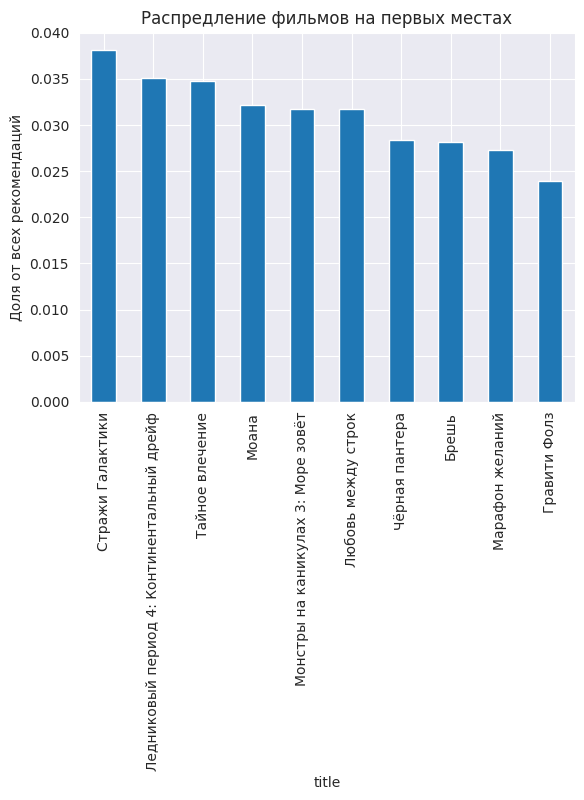

In [ ]:
first_items = pd.DataFrame([x[0] for x in val_recs_train["als_base_recs"].values], columns=["item_id"])
first_items = (
    first_items.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распредление фильмов на первых местах")
plt.show()


In [ ]:
def get_similar_films(model, title, N=10):
    item_id = items_df[items_df["title"] == title]['item_id'].values[0]

    similar_encoded_ids = model.model.similar_items(
        model.item_encoder.transform([item_id]), N=N, filter_items=model.item_encoder.transform([item_id])
    )[0][0]
    similar_ids = model.item_encoder.inverse_transform(similar_encoded_ids)
    return items_df[items_df["item_id"].isin(similar_ids)]["title"]


In [ ]:
get_similar_films(als_base, "Стражи Галактики")

607                      Первый мститель
2699                      Капитан Марвел
3061                      Доктор Стрэндж
3361     Первый мститель: Противостояние
4376              Мстители: Эра Альтрона
8525       Первый мститель: Другая война
8950                         Морской бой
9903                                 Тор
10537          Стражи Галактики. Часть 2
11377                         Цветок зла
Name: title, dtype: object

In [ ]:
get_similar_films(als_base, "Ла-ла ленд")

410                  Арвентур
795            Утиные истории
1279      Возвращение Будулая
1538                 Малавита
2628           Почти знаменит
4881     В начале славных дел
5223         Корпорация «Еда»
9324                    Врачи
10337       Двое во Вселенной
11138           Другой взгляд
Name: title, dtype: object

Со "Стражами Галактики" модель справилась неплохо, а вот "Утиные истории" и "Ла-ла ленд" мало похожи

хочу попробовать подобрать гиперпараметры. сравнивать буду по recall, потому что хочу в начале хотя бы отбирать в топ10 как можно больше похожих

In [ ]:
factors = [2, 4, 8, 32, 64, 128, 256, 512]
iters = [1, 5, 10, 25]
regularizations = [1e-3, 1e-2, 1e-1, 0]

best_score = -1
best_model = None
best_params = dict()

history = []

train_users_df = val_recs[val_recs['user_id'].isin(train_users)]
val_recs_train = val_recs.loc[val_recs['user_id'].isin(train_users)].copy()

for factor in factors:
    for n_iters in iters:
        for reg in regularizations:
            als = ALS(factors=factor, iterations=n_iters, regularization=reg)
            als.fit(train_data)

            recs = als.predict(train_users_df)
            val_recs_train['recs'] = recs
            score = evaluate_recommender(val_recs_train, model_preds_col="recs")['recall']

            params = {
                'factors': factor,
                'iterations': n_iters,
                'regularization': reg,
            }

            history.append({'params': params, 'score': score})

            if score > best_score:
                best_score = score
                best_params = params
                best_model = als

            print('best pararms:', best_params)
            print('best score:', best_score)

            best_model.model.save('/content/drive/MyDrive/ml_tink/best_als_model')
            with open('/content/drive/MyDrive/ml_tink/history_als_model', 'wb') as f:
                np.save(f, np.array(history))

In [ ]:
history = []
with open('/content/drive/MyDrive/ml_tink/history_als_model', 'rb') as f:
      history = np.load(f, allow_pickle=True)

In [ ]:
best_score = 0
best_params = None
for val in history:
    if val['score'] > best_score:
        best_score = val['score']
        best_params = val['params']

print("best score:", best_score)
print('best params:', best_params)

best score: 0.06306749646638496
best params: {'factors': 2, 'iterations': 5, 'regularization': 0}


In [ ]:
als_base_tuned = ALS(factors=2, iterations=5, regularization=0, random_state=42)
als_base_tuned.fit(train_data)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
recs = als_base_tuned.predict(train_users_df)
val_recs_train['recs'] = recs
score = evaluate_recommender(val_recs_train, model_preds_col="recs")
print('als base tuned model, val score:', score)

predicting:   0%|          | 0/4509 [00:00<?, ?it/s]

als base tuned model, val score: {'ndcg': 0.13113836099615236, 'recall': 0.06171474261862113}


In [ ]:
train_test_users = np.intersect1d(train_data['user_id'].unique(), test_part['user_id'].values)
test_recs = als_base_tuned.predict(test_part[test_part['user_id'].isin(train_test_users)], to_filter=val_recs)
test_recs_train = test_part.loc[test_part['user_id'].isin(train_test_users)].copy()
test_recs_train['als_base_tuned_recs'] = test_recs
print('als base tuned model, test score:', evaluate_recommender(test_recs_train, model_preds_col="als_base_tuned_recs"))

predicting:   0%|          | 0/15474 [00:00<?, ?it/s]

als base tuned model, test score: {'ndcg': 0.1580153457309521, 'recall': 0.07096839799573373}


посмотрим на рекоммендации для пользователя 5915

In [ ]:
user = 5915
rec_movies = val_recs_train.loc[val_recs_train['user_id'] == user, 'recs'].values[0]
items_df.loc[items_df['item_id'].isin(rec_movies)]

,item_id,content_type,title,title_orig,release_year,genres,countries,for_kids,age_rating,studios,...,description,keywords,cnt_users,cnt_users_with_sex,female_r,male_r,age_major,age_median,income_major,income_median
158,4880,series,Афера,Afera,2021.0,комедии,Россия,0.0,18.0,NaN,...,"Смотри:- как кино- как сериалКарантин окончен,...","Афера, Аферисты, Карантин, Пандемия, Карантин ...",13095.0,10211.0,0.436098,0.563902,age_35_44,age_35_44,income_20_40,income_20_40
572,15297,series,Клиника счастья,Klinika schast'ya,2021.0,"драмы, мелодрамы",Россия,0.0,18.0,NaN,...,"Успешный сексолог Алена уверена, что нашла фор...","Клиника счастья, Клиника, Счастье, Клиника сча...",40997.0,26380.0,0.682183,0.317817,age_25_34,age_35_44,income_20_40,income_20_40
1429,10440,series,Хрустальный,Khrustal'nyy,2021.0,"триллеры, детективы",Россия,0.0,18.0,NaN,...,Сергей Смирнов — один из лучших «охотников на ...,"хруст, хрусталь, хруста, хрус, полицейский, пе...",42360.0,27958.0,0.545998,0.454002,age_35_44,age_35_44,income_20_40,income_20_40
4809,9728,film,Гнев человеческий,Wrath of Man,2021.0,"боевики, триллеры","Великобритания, США",0.0,18.0,NaN,...,Грузовики лос-анджелесской инкассаторской комп...,"ограбление, криминальный авторитет, месть, пер...",23474.0,19686.0,0.430153,0.569847,age_25_34,age_35_44,income_20_40,income_20_40
4921,13865,film,Девятаев,V2. Escape from Hell,2021.0,"драмы, военные, приключения",Россия,0.0,12.0,NaN,...,Военно-исторический блокбастер от режиссёров Т...,"Девятаев, Девятаева, Девят, Девя, Девята, Девя...",27522.0,21996.0,0.402073,0.597927,age_35_44,age_35_44,income_20_40,income_20_40
5064,4151,series,Секреты семейной жизни,NaN,2021.0,комедии,Россия,0.0,18.0,NaN,...,У Никиты и Полины всё начиналось прекрасно: об...,"брызги крови, кровь, жестокое обращение с живо...",20751.0,15026.0,0.569546,0.430454,age_25_34,age_35_44,income_20_40,income_20_40
5522,9996,series,Немцы,Nemtsy,2021.0,драмы,Россия,0.0,16.0,NaN,...,На журналиста-оппозиционера Антона Эбергарда с...,"немцы, немец, про немцев, по мотивам романа, п...",8647.0,6311.0,0.454128,0.545872,age_35_44,age_35_44,income_20_40,income_20_40
9137,3734,film,Прабабушка легкого поведения,Prababushka lyogkogo povedeniya,2021.0,комедии,Россия,0.0,16.0,NaN,...,"1980 год, вся страна следит за событиями моско...",", 2021, россия, прабабушка, легкого, поведения",15051.0,12140.0,0.524465,0.475535,age_25_34,age_35_44,income_20_40,income_20_40
10305,2657,series,Подслушано,Podslushano,2021.0,"драмы, триллеры",Россия,0.0,16.0,NaN,...,Смотри:- как кино- как сериалПодростковый псих...,"подслушано, подслушано в контакте, социальная ...",16276.0,9781.0,0.552806,0.447194,age_25_34,age_35_44,income_20_40,income_20_40
11506,142,film,Маша,Masha,2020.0,"драмы, триллеры",Россия,0.0,16.0,NaN,...,13-летняя Маша растёт между боксёрским рингом ...,"Фильм Маша, Маша фильм 2021, Смотреть фильм Ма...",10503.0,8034.0,0.524645,0.475355,age_35_44,age_35_44,income_20_40,income_20_40


кажется рекомендации стали еще хуже, чем с базовой моделью

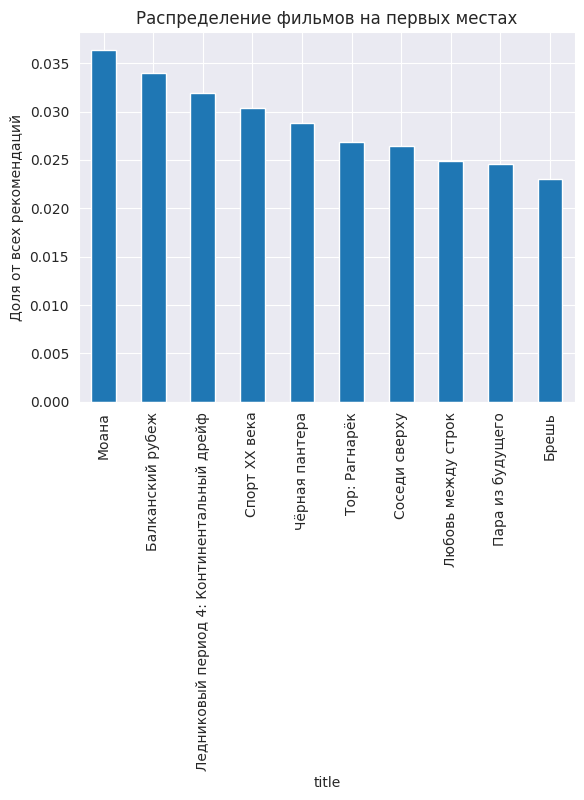

In [ ]:
first_items = pd.DataFrame([x[0] for x in val_recs_train["als_base_recs"].values], columns=["item_id"])
first_items = (
    first_items.merge(items_df[["item_id", "title"]], on="item_id").groupby("title").size().sort_values(ascending=False)
)
first_items /= first_items.sum()
first_items.head(10).plot(kind="bar")
plt.ylabel("Доля от всех рекомендаций")
plt.title("Распределение фильмов на первых местах")
plt.show()


In [ ]:
get_similar_films(als_base_tuned, "Стражи Галактики")

868                                       Везучая
1858                                  Дитя робота
4654                            Джиперс Криперс 3
5064                       Секреты семейной жизни
5392                          Большое путешествие
6557                          Петербургские тайны
10764              «Дикая Мята». Онлайн-фестиваль
10870                                 Поза лотоса
10927                                 Живой товар
11546    Бегущий в лабиринте: Лекарство от смерти
Name: title, dtype: object

In [ ]:
get_similar_films(als_base_tuned, "Ла-ла ленд")

3155                               Вся наша надежда
3574                       Селфи. Хаос и творчество
3693                                       Паранойя
3977                               Без обязательств
6927     В винном отражении (с русскими субтитрами)
7978                            У реки два берега 2
8281                              Рейс в один конец
8832                             Скрюченный домишко
9745                                   Закрой глаза
10853                                Другая женщина
Name: title, dtype: object

In [ ]:
# to do: посмотреть как часто советуем наиболее популярные айтемы

In [ ]:
val_recs_train['als_base_recs']
top100movies

In [ ]:
top100movies

Int64Index([15297, 10440, 13865,  9728,  4151,  3734,  2657,   142,  6809,
             4880,  4740,  8636, 11237,  1844,  7571,  9996, 12995, 14741,
            14431,  4457,  7417, 14703,  4495,  4436,   849,  7102,  5658,
            13018,  7107, 12192, 11778,  1819,  7626, 12173, 14470,   101,
             1132, 12981, 10464,  3935, 16166,  9169,  1916, 14317, 11310,
            12463,  3076,  7829, 12501,  6402, 14901, 16228,   657, 16361,
            15464,  3182,  9194,  1287, 12324, 10772,  5693, 10942,  6626,
            13915, 14359, 14461, 10077, 15531,  8447,  8373, 12770,  8618,
             1449,  5424, 11754,  1785, 11640,  5287,  5732, 12743,  4382,
             6443,  6192,  5250,  7582, 12841, 15915, 10761,  5411,  7210,
             3071, 16270,  5803, 10436,    14,    24, 13243,  1554,  6455,
             1053],
           dtype='int64')

In [ ]:
top100movies_in_recs = dict()
for recs in val_recs_train['als_base_recs'].values:
    for rec in recs:
        if rec in top100movies:
            if rec in top100movies_in_recs:
                top100movies_in_recs[rec] += 1
            else:
                top100movies_in_recs[rec] = 1

In [ ]:
top100movies_als_base_stats = []
for movie in top100movies:
    if movie in top100movies_in_recs:
        top100movies_als_base_stats.append((movie, top100movies_in_recs[movie] / len(val_recs_train)))
top100movies_als_base_stats[:10]

[(15297, 0.005988023952095809),
 (10440, 0.026169882457307607),
 (13865, 0.015746285207363053),
 (9728, 0.004879130627633622),
 (4151, 0.009536482590374805),
 (3734, 0.023730317143490796),
 (2657, 0.021956087824351298),
 (142, 0.009314703925482368),
 (6809, 0.010201818585052118),
 (4880, 0.018851186515857175)]

In [ ]:
top100movies_in_tuned_recs = dict()
for recs in val_recs_train['recs'].values:
    for rec in recs:
        if rec in top100movies:
            if rec in top100movies_in_tuned_recs:
                top100movies_in_tuned_recs[rec] += 1
            else:
                top100movies_in_tuned_recs[rec] = 1

top100movies_als_base_tuned_stats = []
for movie in top100movies:
    if movie in top100movies_in_tuned_recs:
        top100movies_als_base_tuned_stats.append((movie, top100movies_in_tuned_recs[movie] / len(val_recs_train)))
top100movies_als_base_tuned_stats[:10]

[(15297, 0.5555555555555556),
 (10440, 0.8966511421601242),
 (13865, 0.8664892437347527),
 (9728, 0.8673763583943225),
 (4151, 0.9441117764471058),
 (3734, 0.9270348192503881),
 (2657, 0.9580838323353293),
 (142, 0.9631847416278554),
 (6809, 0.18984253714792637),
 (4880, 0.9534264803725881)]

**вывод:**

после тюна стали предсказывать более популярные фильмы, поэтому скор слегка подрос относительно базовой модели, но вероятно из-за того, что в затюненной модели только два латентных фактора, модели не удается предсказывать более индивидуальные похожие, а она просто ухадит в самое популярное. у базовой модели со ста латентыми факторами удается находить действительно более похожие айтемы, но из-за большого кол-ва фильмов и маленького количества статистики просаживается значение метрики

я думаю далеко только на одной модели ALS не уедешь, и еще сейчас мне кажется большим упущением не использовать кучу данных пользователей и фильмов, а фокусироваться только на просмотрах, которые несут мало информации

я хочу попробовать построить двух ступенчатую модель. на первом этапе обучим модель, которая будет показывать похожесть айтемов. в итоге получим вектора айтемов - их можно взять или из ALS, или можно попробовать обучит implicit knn.

далее на втором этапе обучим катбуст на tupels (юзер, айтем, и вспомогательные данные) на вероятность того, что юзер посмотрит данный айтем. положительный кандидотов можно брать из первого этапа отсекая по косинусу между векторами юзера и айтема, а негативные нассемплировать из того, что пользователь точно не будет смотреть


### разбиение на трейн для двух этапов

сделаем такое разбиение:
- 1 неделя с конца (последняя) - валидация
- 2 и 3 недели с конца - обучение бустинга
- 4 неделя с конца - валидации 1-ого этапа
- 5 и далее - обучение item-item

In [ ]:
train2 = train_part.loc[train_part['last_watch_dt'].isin(dates[-21:-7])].copy()
len(train2)

188015

In [ ]:
print('колво просмотренным фильмов на пользователей за 2 и 3 неделю с конца')
cnt_items = train2.loc[train2['watched_pct'] > 0].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id': 'cnt'}).sort_values('cnt')
cnt_items['cnt'].value_counts(normalize=True)[:21]

колво просмотренным фильмов на пользователей за 2 и 3 неделю с конца


1     0.663481
2     0.187772
3     0.073708
4     0.032603
5     0.017239
6     0.009874
7     0.005367
8     0.003216
9     0.001946
10    0.001454
11    0.000830
12    0.000645
13    0.000533
14    0.000328
16    0.000236
15    0.000205
18    0.000082
20    0.000072
19    0.000072
17    0.000061
22    0.000051
Name: cnt, dtype: float64

In [ ]:
val_data = train_part.loc[train_part['last_watch_dt'].isin(dates[-28:-21])]
val_recs1 = val_data[val_data['watched_pct'] > 0].groupby('user_id')['item_id'].apply(list).reset_index(name='ground_truth')
val_recs1['len'] = val_recs1['ground_truth'].apply(lambda x: len(x))
val_recs1 = val_recs1.loc[val_recs1['len'] >= 3]
print('среднее открытых пользователями фильмов', np.mean(val_recs1['len']))
print('кол-во пользователей', len(val_recs1))

среднее открытых пользователями фильмов 3.9176493710691824
кол-во пользователей 5088


In [ ]:
val_recs1['len'].value_counts()

3     2955
4     1106
5      489
6      230
7      126
8       68
9       39
10      19
11      17
13       8
12       7
16       6
14       5
15       2
19       2
17       2
18       1
36       1
29       1
20       1
61       1
22       1
23       1
Name: len, dtype: int64

In [ ]:
train1 = train_part.loc[train_part['last_watch_dt'].isin(dates[:-28])]

### 1 этап

**als**

In [ ]:
als = ALS()
als.fit(train1)

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
intersect_train_val_users1 = np.intersect1d(train1['user_id'].unique(), val_recs1['user_id'].values)
print(len(intersect_train_val_users1))

3497


In [ ]:
recs = als.predict(val_recs1[val_recs1['user_id'].isin(intersect_train_val_users1)])
intersect_train_val_recs1 = val_recs1.loc[val_recs1['user_id'].isin(intersect_train_val_users1)].copy()
intersect_train_val_recs1['als'] = recs
print('val score:', evaluate_recommender(intersect_train_val_recs1, model_preds_col="als"))

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

val score: {'ndcg': 0.038716527280013305, 'recall': 0.016919942209476093}


In [ ]:
get_similar_films(als, "Стражи Галактики")

607                      Первый мститель
2517                  Железный человек 2
3361     Первый мститель: Противостояние
4376              Мстители: Эра Альтрона
4683                     Человек-муравей
8525       Первый мститель: Другая война
9795                  Железный человек 3
9903                                 Тор
10537          Стражи Галактики. Часть 2
10584                   Железный человек
Name: title, dtype: object

In [ ]:
get_similar_films(als, "Ла-ла ленд")

134                               Бастард
3507             Добро пожаловать в Китай
3886                         Удовольствие
5384                   Останемся друзьями
6142                      Игра без правил
7144              Апокалипсис Стоунхенджа
7296                   Искусство молчания
8329                 ПреКрасная Шапочка 3
10252    Катастрофа на День независимости
10664                              Сирена
Name: title, dtype: object

**als with watch percantege > 0**

In [ ]:
als_small = ALS()
als_small.fit(train1.loc[train1['watched_pct'] > 0])

  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
intersect_train_val_users1 = np.intersect1d(train1.loc[train1['watched_pct'] > 0, 'user_id'].unique(), val_recs1['user_id'].values)
print('cnt intercect users in train1 and val1', len(intersect_train_val_users1))

recs = als_small.predict(val_recs1[val_recs1['user_id'].isin(intersect_train_val_users1)])
intersect_train_val_recs1 = val_recs1.loc[val_recs1['user_id'].isin(intersect_train_val_users1)].copy()
intersect_train_val_recs1['als_small'] = recs
print('val score on als with watched percentage filter:', evaluate_recommender(intersect_train_val_recs1, model_preds_col="als_small"))

cnt intercect users in train1 and val1 3415


predicting:   0%|          | 0/3415 [00:00<?, ?it/s]

val score on als with watched percentage filter: {'ndcg': 0.03627327124695024, 'recall': 0.015124961635768083}


In [ ]:
get_similar_films(als_small, "Стражи Галактики")

607                      Первый мститель
3061                      Доктор Стрэндж
3361     Первый мститель: Противостояние
4683                     Человек-муравей
5305             Люди Икс: Тёмный Феникс
6631                               Чужие
8525       Первый мститель: Другая война
9795                  Железный человек 3
9903                                 Тор
10537          Стражи Галактики. Часть 2
Name: title, dtype: object

In [ ]:
get_similar_films(als_small, "Ла-ла ленд")

134                                             Бастард
645      Изобретатель: Жажда крови в Силиконовой долине
5120                                             Страйк
6002                                            Куколка
8074                                           На грани
8096                            [4K] На глубине 6 футов
8675                              Возвращение резидента
9307                                             Хандра
9706                               Эдем. Райский остров
10168                       С любимыми не расставайтесь
Name: title, dtype: object

**item item cosine dist**

In [ ]:
from implicit.nearest_neighbours import CosineRecommender, TFIDFRecommender, BM25Recommender

In [ ]:
class CosineModel(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(self, k: int = 20, **kwargs) -> None:
        super().__init__()
        self.model = CosineRecommender(K=k)
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10, to_filter: pd.DataFrame = None) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            to_filter_items = None
            if to_filter is not None and len(to_filter) > 0:
                orig_user = self.user_encoder.inverse_transform([user])[0]
                vals = to_filter.loc[to_filter['user_id'] == orig_user, 'ground_truth'].values
                if len(vals) > 0:
                    vals = np.intersect1d(vals[0], self.item_encoder.classes_)
                    to_filter_items = self.item_encoder.transform(vals)
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn, filter_items=to_filter_items)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [ ]:
cosine_model = CosineModel()
cosine_model.fit(train1)

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008396387100219727 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

In [ ]:
intersect_train_val_users1 = np.intersect1d(train1['user_id'].unique(), val_recs1['user_id'].values)
print('cnt intercect users in train1 and val1', len(intersect_train_val_users1))

recs = cosine_model.predict(val_recs1[val_recs1['user_id'].isin(intersect_train_val_users1)])
intersect_train_val_recs1 = val_recs1.loc[val_recs1['user_id'].isin(intersect_train_val_users1)].copy()
intersect_train_val_recs1['cos_recs'] = recs
print('val score on als with watched percentage filter:', evaluate_recommender(intersect_train_val_recs1, model_preds_col="cos_recs"))

cnt intercect users in train1 and val1 3497


predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

val score on als with watched percentage filter: {'ndcg': 0.09258932422398422, 'recall': 0.04629290355602563}


In [ ]:
get_similar_films(cosine_model, "Стражи Галактики")

607                                Первый мститель
1248                                      Мстители
3061                                Доктор Стрэндж
3361               Первый мститель: Противостояние
4683                               Человек-муравей
5605                             Тор: Царство тьмы
6262     Универсальный солдат 3: Неоконченное дело
8115                 Мстители: Война бесконечности
8525                 Первый мститель: Другая война
10537                    Стражи Галактики. Часть 2
Name: title, dtype: object

In [ ]:
get_similar_films(cosine_model, "Ла-ла ленд")

2347                        Дежа вю
2960                        Девочка
3221           Универсальный солдат
7296             Искусство молчания
8139     Чикагская печатная машинка
8985                  Дневной поезд
9198                 Большая любовь
9371                   Снег и пепел
10513                        Родина
11339                Детство лидера
Name: title, dtype: object

эта модель на по скору и двум примерам похожих фильмов дает надежду

посмотрим, как часто рекомендуются популярные фильмы

In [ ]:
top100movies_in_cos_model = dict()
for recs in intersect_train_val_recs1['cos_recs'].values:
    for rec in recs:
        if rec in top100movies:
            if rec in top100movies_in_cos_model:
                top100movies_in_cos_model[rec] += 1
            else:
                top100movies_in_cos_model[rec] = 1

top100movies_cos_model_stats = []
for movie in top100movies:
    if movie in top100movies_in_cos_model:
        top100movies_cos_model_stats.append((movie, top100movies_in_cos_model[movie] / len(intersect_train_val_recs1)))
top100movies_cos_model_stats[:10]

[(15297, 0.18530168716042322),
 (10440, 0.2739490992279096),
 (13865, 0.2610809265084358),
 (9728, 0.1975979410923649),
 (4151, 0.24077780955104375),
 (3734, 0.1721475550471833),
 (2657, 0.11752931083786103),
 (142, 0.26251072347726623),
 (6809, 0.009436659994280812),
 (4880, 0.24306548470117242)]

в целом, значения не такие критичные, как с затюненной ALS

In [ ]:
ks = [1, 3, 5, 7, 10, 15, 20]

best_k = None
best_model = None
best_score = -1
history = []

for k in tqdm(ks):
    model = CosineModel(k)
    model.fit(train1)

    recs = model.predict(val_recs1[val_recs1['user_id'].isin(intersect_train_val_users1)])
    intersect_train_val_recs1['recs'] = recs

    score = evaluate_recommender(intersect_train_val_recs1, model_preds_col="recs")['recall']

    history.append({'k': k, 'score': score})

    if score > best_score:
        best_score = score
        best_k = k
        best_model = model

    print('k:', k, "cur score:", score)
    print('best k:', best_k, "best score:", best_score)

    best_model.model.save('/content/drive/MyDrive/ml_tink/best_cosine_model')
    with open('/content/drive/MyDrive/ml_tink/history_cosine_model', 'wb') as f:
        np.save(f, np.array(history))

  0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009262561798095703 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 1 cur score: 0.0
best k: 1 best score: 0.0


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.010119199752807617 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 3 cur score: 0.0229404136097268
best k: 3 best score: 0.0229404136097268


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.010303974151611328 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 5 cur score: 0.03453903343658166
best k: 5 best score: 0.03453903343658166


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009816408157348633 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 7 cur score: 0.03857839266736548
best k: 7 best score: 0.03857839266736548


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008946657180786133 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 10 cur score: 0.04425091415344144
best k: 10 best score: 0.04425091415344144


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.00831460952758789 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 15 cur score: 0.04581571972882752
best k: 15 best score: 0.04581571972882752


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.010992288589477539 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 20 cur score: 0.04629290355602563
best k: 20 best score: 0.04629290355602563


In [ ]:
print('best k:', best_k, "best score:", best_score)

best k: 20 best score: 0.04629290355602563


**tf idf recommender**

In [ ]:
class TFIDFModel(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(self, k: int = 20, **kwargs) -> None:
        super().__init__()
        self.model = TFIDFRecommender(K=k)
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10, to_filter: pd.DataFrame = None) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            to_filter_items = None
            if to_filter is not None and len(to_filter) > 0:
                orig_user = self.user_encoder.inverse_transform([user])[0]
                vals = to_filter.loc[to_filter['user_id'] == orig_user, 'ground_truth'].values
                if len(vals) > 0:
                    vals = np.intersect1d(vals[0], self.item_encoder.classes_)
                    to_filter_items = self.item_encoder.transform(vals)
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn, filter_items=to_filter_items)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [ ]:
ks = [10, 15, 20] # надо 10 рекомендаций, поэтому лучше брать как минимум 10 соседей

best_k = None
best_tfidf_model = None
best_score = -1
tfidf_history = []

for k in tqdm(ks):
    model = TFIDFModel(k)
    model.fit(train1)

    recs = model.predict(val_recs1[val_recs1['user_id'].isin(intersect_train_val_users1)])
    intersect_train_val_recs1['recs'] = recs

    score = evaluate_recommender(intersect_train_val_recs1, model_preds_col="recs")['recall']

    tfidf_history.append({'k': k, 'score': score})

    if score > best_score:
        best_score = score
        best_k = k
        best_tfidf_model = model

    print('k:', k, "cur score:", score)
    print('best k:', best_k, "best score:", best_score)

    best_tfidf_model.model.save('/content/drive/MyDrive/ml_tink/best_tfidf_model')
    with open('/content/drive/MyDrive/ml_tink/history_tfidf_model', 'wb') as f:
        np.save(f, np.array(tfidf_history))

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008156299591064453 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 10 cur score: 0.04581550309292314
best k: 10 best score: 0.04581550309292314


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008119583129882812 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 15 cur score: 0.04788562738924133
best k: 15 best score: 0.04788562738924133


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008354902267456055 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 20 cur score: 0.048870144730635987
best k: 20 best score: 0.048870144730635987


In [ ]:
recs = best_tfidf_model.predict(val_recs1[val_recs1['user_id'].isin(intersect_train_val_users1)])
intersect_train_val_recs1['tfidf_recs'] = recs
print('val1 score in tfidf model:', evaluate_recommender(intersect_train_val_recs1, model_preds_col="recs"))

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

val1 score in tfidf model: {'ndcg': 0.09854376377836065, 'recall': 0.048870144730635987}


In [ ]:
get_similar_films(cosine_model, "Стражи Галактики"), get_similar_films(best_tfidf_model, "Стражи Галактики")

(607                                Первый мститель
 1248                                      Мстители
 3061                                Доктор Стрэндж
 3361               Первый мститель: Противостояние
 4683                               Человек-муравей
 5605                             Тор: Царство тьмы
 6262     Универсальный солдат 3: Неоконченное дело
 8115                 Мстители: Война бесконечности
 8525                 Первый мститель: Другая война
 10537                    Стражи Галактики. Часть 2
 Name: title, dtype: object,
 607                                Первый мститель
 1248                                      Мстители
 3061                                Доктор Стрэндж
 3361               Первый мститель: Противостояние
 4683                               Человек-муравей
 5605                             Тор: Царство тьмы
 6262     Универсальный солдат 3: Неоконченное дело
 8115                 Мстители: Война бесконечности
 8525                 Первый мстите

In [ ]:
get_similar_films(cosine_model, "Ла-ла ленд"), get_similar_films(best_tfidf_model, "Ла-ла ленд")

(2347                        Дежа вю
 2960                        Девочка
 3221           Универсальный солдат
 7296             Искусство молчания
 8139     Чикагская печатная машинка
 8985                  Дневной поезд
 9198                 Большая любовь
 9371                   Снег и пепел
 10513                        Родина
 11339                Детство лидера
 Name: title, dtype: object,
 2051                     Мистер Пип
 2347                        Дежа вю
 2960                        Девочка
 3221           Универсальный солдат
 7296             Искусство молчания
 8139     Чикагская печатная машинка
 8985                  Дневной поезд
 9198                 Большая любовь
 9371                   Снег и пепел
 10513                        Родина
 Name: title, dtype: object)

In [ ]:
top100movies_in_tfidf_model = dict()
for recs in intersect_train_val_recs1['tfidf_recs'].values:
    for rec in recs:
        if rec in top100movies:
            if rec in top100movies_in_tfidf_model:
                top100movies_in_tfidf_model[rec] += 1
            else:
                top100movies_in_tfidf_model[rec] = 1

top100movies_tfidf_model_stats = []
for movie in top100movies:
    if movie in top100movies_in_tfidf_model:
        top100movies_tfidf_model_stats.append((movie, top100movies_in_tfidf_model[movie] / len(intersect_train_val_recs1)))

print('recs of popular items in tfdidf model:')
print(top100movies_tfidf_model_stats[:10])

print('recs of popular items in cosine model:')
print(top100movies_cos_model_stats[:10])

recs of popular items in tfdidf model:
[(15297, 0.20274521018015443), (10440, 0.30025736345438947), (13865, 0.29854160709179295), (9728, 0.22161853016871605), (4151, 0.2630826422647984), (3734, 0.19187875321704317), (2657, 0.127537889619674), (142, 0.27966828710323133), (6809, 0.009722619388046897), (4880, 0.251644266514155)]
recs of popular items in cosine model:
[(15297, 0.18530168716042322), (10440, 0.2739490992279096), (13865, 0.2610809265084358), (9728, 0.1975979410923649), (4151, 0.24077780955104375), (3734, 0.1721475550471833), (2657, 0.11752931083786103), (142, 0.26251072347726623), (6809, 0.009436659994280812), (4880, 0.24306548470117242)]


**bm25 recommender**

In [ ]:
class ItemItemRecommended(BaseRecommender):
    # здесь вынесены только основные гиперпараметры модели, все вы можете посмотреть в документации
    def __init__(self, model) -> None:
        super().__init__()
        self.model = model
        self.trained = False

    def fit(
        self, df: pd.DataFrame, item_col: str = "item_id", user_col: str = "user_id", value_col: str = None
    ) -> None:
        self.user_encoder = LabelEncoder()
        self.item_encoder = LabelEncoder()
        user_ids = self.user_encoder.fit_transform(df[user_col])
        item_ids = self.item_encoder.fit_transform(df[item_col])
        if value_col is None:
            counts = np.ones(len(df))
        else:
            counts = df[value_col].values

        matrix_shape = len(self.user_encoder.classes_), len(self.item_encoder.classes_)

        self.sparse = csr_matrix((counts, (user_ids, item_ids)), shape=matrix_shape)
        self.model.fit(self.sparse)

        self.trained = True

    def predict(self, df: pd.DataFrame, topn: int = 10, to_filter: pd.DataFrame = None) -> List[np.ndarray]:
        assert self.trained

        all_recs = []

        users = self.user_encoder.transform(df["user_id"])
        for user in tqdm(users, desc="predicting", leave=False):
            to_filter_items = None
            if to_filter is not None and len(to_filter) > 0:
                orig_user = self.user_encoder.inverse_transform([user])[0]
                vals = to_filter.loc[to_filter['user_id'] == orig_user, 'ground_truth'].values
                if len(vals) > 0:
                    vals = np.intersect1d(vals[0], self.item_encoder.classes_)
                    to_filter_items = self.item_encoder.transform(vals)
            encoded_rec_items = self.model.recommend(user, user_items=self.sparse[user], N=topn, filter_items=to_filter_items)[0]
            all_recs.append(self.item_encoder.inverse_transform(encoded_rec_items))

        return all_recs

In [ ]:
ks = [10, 15, 20] # надо 10 рекомендаций, поэтому лучше брать как минимум 10 соседей

best_k = None
best_bm25_model = None
best_score = -1
bm25_history = []

for k in tqdm(ks):
    model = ItemItemRecommended(BM25Recommender(k))
    model.fit(train1)

    recs = model.predict(val_recs1[val_recs1['user_id'].isin(intersect_train_val_users1)])
    intersect_train_val_recs1['recs'] = recs

    score = evaluate_recommender(intersect_train_val_recs1, model_preds_col="recs")['recall']

    bm25_history.append({'k': k, 'score': score})

    if score > best_score:
        best_score = score
        best_k = k
        best_bm25_model = model

    print('k:', k, "cur score:", score)
    print('best k:', best_k, "best score:", best_score)

    best_bm25_model.model.save('/content/drive/MyDrive/ml_tink/best_bm25_model')
    with open('/content/drive/MyDrive/ml_tink/history_bm25_model', 'wb') as f:
        np.save(f, np.array(bm25_history))

  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.011228561401367188 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 10 cur score: 0.017040789731667626
best k: 10 best score: 0.017040789731667626


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.008158683776855469 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 15 cur score: 0.017505049065641376
best k: 15 best score: 0.017505049065641376


/usr/local/lib/python3.10/dist-packages/implicit/utils.py:138: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 0.009049415588378906 seconds
  warnings.warn(


  0%|          | 0/11199 [00:00<?, ?it/s]

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

k: 20 cur score: 0.018291760368509383
best k: 20 best score: 0.018291760368509383


In [ ]:
recs = best_bm25_model.predict(val_recs1[val_recs1['user_id'].isin(intersect_train_val_users1)])
intersect_train_val_recs1['bm25_recs'] = recs
print('val1 score in bm25 model:', evaluate_recommender(intersect_train_val_recs1, model_preds_col="bm25_recs"))

predicting:   0%|          | 0/3497 [00:00<?, ?it/s]

val1 score in bm25 model: {'ndcg': 0.04121076639868622, 'recall': 0.018291760368509383}


In [ ]:
get_similar_films(cosine_model, "Стражи Галактики"), get_similar_films(best_bm25_model, "Стражи Галактики")

(607                                Первый мститель
 1248                                      Мстители
 3061                                Доктор Стрэндж
 3361               Первый мститель: Противостояние
 4683                               Человек-муравей
 5605                             Тор: Царство тьмы
 6262     Универсальный солдат 3: Неоконченное дело
 8115                 Мстители: Война бесконечности
 8525                 Первый мститель: Другая война
 10537                    Стражи Галактики. Часть 2
 Name: title, dtype: object,
 607                      Первый мститель
 3061                      Доктор Стрэндж
 3361     Первый мститель: Противостояние
 3411              Люди Икс: Первый класс
 4683                     Человек-муравей
 5605                   Тор: Царство тьмы
 6703               Человек-муравей и Оса
 8525       Первый мститель: Другая война
 9903                                 Тор
 10537          Стражи Галактики. Часть 2
 Name: title, dtype: object)

In [ ]:
get_similar_films(cosine_model, "Ла-ла ленд"), get_similar_films(best_bm25_model, "Ла-ла ленд")

(2347                        Дежа вю
 2960                        Девочка
 3221           Универсальный солдат
 7296             Искусство молчания
 8139     Чикагская печатная машинка
 8985                  Дневной поезд
 9198                 Большая любовь
 9371                   Снег и пепел
 10513                        Родина
 11339                Детство лидера
 Name: title, dtype: object,
 309                         Местные
 2051                     Мистер Пип
 2302                    Заговорщица
 3221           Универсальный солдат
 4741                   Время женщин
 4801            Старик с пистолетом
 5474      Кровью и потом: Анаболики
 6469              Призрачный гонщик
 8139     Чикагская печатная машинка
 10574               Анна и командор
 Name: title, dtype: object)

**вывод:**
лучше всех справляются модели на основе косинусного и tf-idf расстояний, но tf-idf более мейнстримная, поэтому для второго этапа оставим модель на основе косинусного расстояния

### 2 этап

In [ ]:
len(train2)

188015

In [ ]:
train2

,user_id,item_id,last_watch_dt,total_dur,watched_pct
12,646903,16228,2021-07-23,57375.0,46.0
13,616003,13865,2021-07-17,131.0,2.0
30,205710,10152,2021-07-20,1946.0,38.0
33,513902,3614,2021-07-24,1164.0,5.0
58,312347,3017,2021-07-13,6121.0,100.0
...,...,...,...,...,...
1224490,475933,8694,2021-07-17,5.0,0.0
1224499,971360,10886,2021-07-12,42.0,1.0
1224515,1021046,6186,2021-07-21,14283.0,25.0
1224523,360976,7890,2021-07-13,226.0,0.0


In [ ]:
# отбираем тех юзеров и айтемы, который участвовали в первом этапе
cond = (train2['user_id'].isin(train1['user_id'].values)) & (train2['item_id'].isin(train1['item_id'].values))
train2 = train2.loc[cond].copy()
print(len(train2))

74285


теперь необходимо выбрать таргет. за положительную я беру пару (юзер,айтем), если юзер посмотрет хотя бы 10% фильма

у меня была идея за отрицательные пары взять строки, где пользователь посмотрел меньше 5% фильма, но у большинства таких айтемов более маленькая длина. то есть по сути может быть риск, что мы таким образом говорим модели, что более продолжительные айтемы лучше чем короткие. думаю, если брать отрицательные пары по такому правилу, надо еще добавить несколько отрицательных пар с более длинными айтемами

In [ ]:
train2.loc[train2['watched_pct'] > 10, 'target'] = 1
train2.loc[train2['watched_pct'] <= 5, 'target'] = 0

In [ ]:
# оставляем только юзеров у которых есть позитивные пары

pos_users = train2.loc[train2['target'] == 1, 'user_id'].unique()
train2.drop(index=train2.loc[~train2['user_id'].isin(pos_users)].index, inplace=True)

In [ ]:
# оставим для каждого юзера 20 последних просмотренных положительных айтемов

cnt_items_per_user = train2.loc[train2['target'] == 1].groupby('user_id')['item_id'].count().reset_index().rename(columns={'item_id': 'cnt'})
for user in cnt_items_per_user.loc[cnt_items_per_user['cnt'] > 20, 'user_id'].values:
    items_to_drop = train2.loc[(train2['user_id'] == user) & (train2['target'] == 1)].sort_values('last_watch_dt').iloc[:-20]['item_id']
    train2.drop(index=train2.loc[train2['item_id'].isin(items_to_drop)].index, inplace=True)


доработаем признаки для фильмов: я хочу добавить количество просмотров за все время, за последний месяц и неделю, и хочу обработать выбросы которые выявили на этапе EDA


In [ ]:
outliers = [849, 7571, 7107, 2657, 10440, 15297, 13865]

In [ ]:
watch_history = train_data.loc[train_data['watched_pct'] > 30].groupby(['item_id', 'last_watch_dt'])['user_id'].count().reset_index().rename(columns={'user_id':'cnt'})

In [ ]:
perc_by_day_watch_history = watch_history.groupby('item_id')['cnt'].quantile(0.90).reset_index().rename(columns={'cnt':'perc'})
print('avg by day for outliers')
perc_by_day_watch_history.loc[perc_by_day_watch_history['item_id'].isin(outliers)]

avg by day for outliers


,item_id,perc
474,849,29.4
1522,2657,133.2
4095,7107,58.2
4363,7571,73.5
6003,10440,446.7
7978,13865,798.4
8830,15297,823.5


In [ ]:
print('max cnt watches in a day for outliers')
hit_by_day = watch_history.loc[watch_history['item_id'].isin(outliers)].groupby('item_id')['cnt'].max().reset_index().rename(columns={'cnt':'max'})
hit_by_day

max cnt watches in a day for outliers


,item_id,max
0,849,89
1,2657,395
2,7107,127
3,7571,202
4,10440,5060
5,13865,1420
6,15297,6641


не хочется удалять эти фильмы из истории, так как потеряем много данных, но есть идея немного выравнить статистику просмотров как признак для фильма

In [ ]:
for outlier in outliers:
    hit = hit_by_day.loc[hit_by_day['item_id'] == outlier, 'max'].values[0]
    perc_cnt = perc_by_day_watch_history.loc[perc_by_day_watch_history['item_id'] == outlier, 'perc'].values[0]
    watch_history.loc[(watch_history['item_id'] == outlier) & (watch_history['cnt'] > perc_cnt), 'cnt'] = perc_cnt

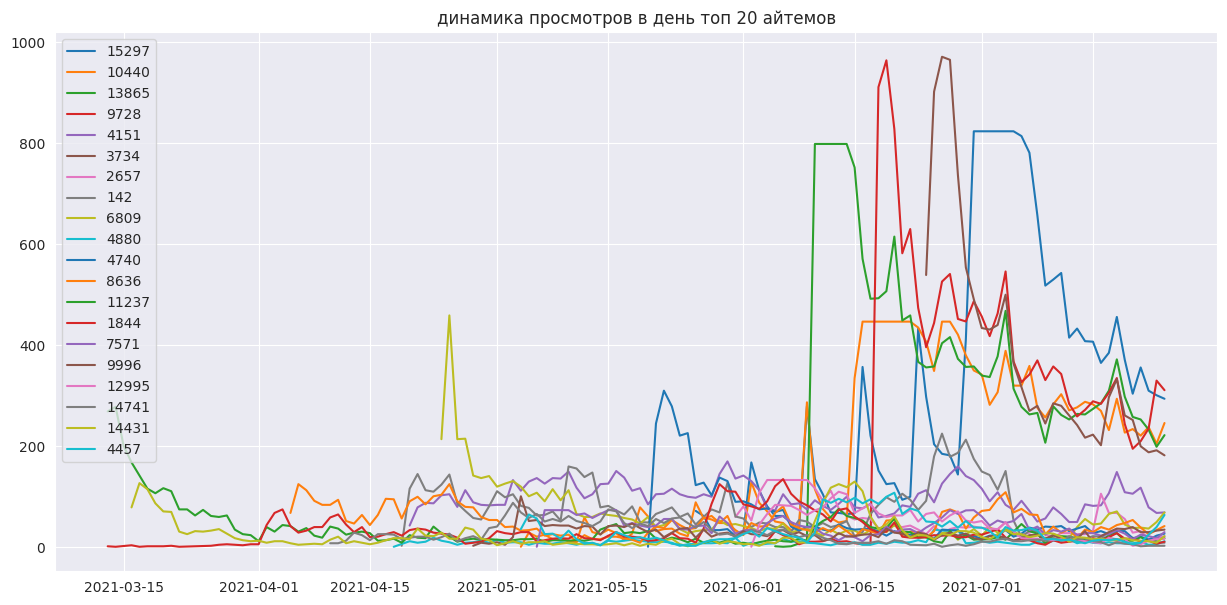

In [ ]:
k = 20
plt.figure(figsize=(15, 7))
for movie in top100movies[:k]:
    movie_watches = watch_history.loc[watch_history['item_id'] == movie]
    plt.plot(movie_watches['last_watch_dt'], movie_watches['cnt'], label=str(movie))
plt.legend()
plt.title('динамика просмотров в день топ 20 айтемов')
plt.show()

кажется так немного сгладили выбросы

In [ ]:
# all watches
all_watches = watch_history.groupby('item_id')['cnt'].sum().reset_index()
items_df = items_df.merge(
    all_watches,
    how='left',
    on='item_id'
).rename(columns={'cnt':'all_time_watches'})

In [ ]:
# last month watches
last_month_watches = watch_history.loc[watch_history['last_watch_dt'].isin(dates[-35:-7])].groupby('item_id')['cnt'].sum().reset_index()
items_df = items_df.merge(
    last_month_watches,
    how='left',
    on='item_id'
).rename(columns={'cnt':'last_month_watches'})


# last week watches
last_week_watches = watch_history.loc[watch_history['last_watch_dt'].isin(dates[-14:-7])].groupby('item_id')['cnt'].sum().reset_index()
items_df = items_df.merge(
    last_week_watches,
    how='left',
    on='item_id'
).rename(columns={'cnt':'last_week_watches'})

In [ ]:
items_df['all_time_watches'].fillna(0, inplace=True)
items_df['last_month_watches'].fillna(0, inplace=True)
items_df['last_week_watches'].fillna(0, inplace=True)

теперь наспемлируем отрицательных примеров

In [ ]:
items_df.columns

Index(['item_id', 'content_type', 'title', 'title_orig', 'release_year',
       'genres', 'countries', 'for_kids', 'age_rating', 'studios', 'directors',
       'actors', 'description', 'keywords', 'cnt_users', 'cnt_users_with_sex',
       'female_r', 'male_r', 'age_major', 'age_median', 'income_major',
       'income_median', 'all_time_watches', 'last_month_watches',
       'last_week_watches'],
      dtype='object')

In [ ]:
# сортируем список жанров чтобы было проще искать одинковые составы

items_df['genres'] = items_df['genres'].apply(lambda s: ', '.join(sorted(s.split(', '))))

In [ ]:
len(train2)

62214

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
users = train2['user_id'].unique()
items_pool = train1['item_id'].unique()

for user in tqdm(users):
    pos = train2.loc[(train2['target'] == 1) & (train2['user_id'] == user), 'item_id'].values
    neg = train2.loc[(train2['target'] == 0) & (train2['user_id'] == user), 'item_id'].values

    # есть уже достаточное колво негативных примеров
    if len(neg) > len(pos) * 2:
        continue

    n_candidates = 2 * len(pos) - len(neg)

    in_val_set = []
    this_val_recs = val_recs.loc[val_recs['user_id'] == user]
    if len(this_val_recs) > 0:
        in_val_set = this_val_recs['ground_truth'].values[0]

    cur_items_pool = np.setdiff1d(items_pool, np.union1d(np.union1d(pos, neg), in_val_set))

    avg_female_r = items_df.loc[items_df['item_id'].isin(pos), 'female_r'].mean()
    if not avg_female_r: avg_female_r = 1

    age_mode = items_df.loc[items_df['item_id'].isin(pos), 'age_major'].mode().values
    if len(age_mode) > 0:
        age_mode = age_mode[0]
    else:
        age_mode = ''

    genres = items_df.loc[items_df['item_id'].isin(pos), 'genres'].unique()

    cond = items_df['item_id'].isin(cur_items_pool) & ((items_df['female_r'] < avg_female_r) | (items_df['age_major'] != age_mode) | (~items_df['genres'].isin(genres)))

    candidates = np.random.choice(items_df.loc[cond, 'item_id'].values, size=n_candidates)

    df_candidates = pd.DataFrame()
    df_candidates['item_id'] = candidates
    df_candidates['user_id'] = user
    df_candidates['target'] = 0

    train2 = train2.append(df_candidates, ignore_index=True)

  0%|          | 0/31701 [00:00<?, ?it/s]

сделаем one-hot кодирование для топопвых жанров

In [ ]:
genres = items_df['genres'].values
genres[:5]

array(['детективы, драмы, зарубежные, мелодрамы',
       'зарубежные, комедии, приключения',
       'боевики, зарубежные, комедии, криминал, триллеры',
       'драмы, зарубежные, мелодрамы',
       'для детей, западные мультфильмы, зарубежные, полнометражные, семейное, сказки'],
      dtype=object)

In [ ]:
all_genres = ', '.join(genres).split(', ')
names, cnts = np.unique(all_genres, return_counts=True)
all_genres = sorted(list(zip(cnts.tolist(), names.tolist())))
all_genres[-10:]

[(991, 'документальное'),
 (1060, 'криминал'),
 (1327, 'русские'),
 (1543, 'боевики'),
 (1591, 'приключения'),
 (2028, 'триллеры'),
 (2040, 'мелодрамы'),
 (2393, 'зарубежные'),
 (3062, 'комедии'),
 (4209, 'драмы')]

In [ ]:
all_genres[-50:-40]

[(35, 'сказки'),
 (39, 'экранизации'),
 (44, 'концерт'),
 (50, 'познавательные'),
 (56, 'фильмы hbo'),
 (61, 'мистика'),
 (62, 'про животных'),
 (62, 'хочу всё знать'),
 (64, 'детские'),
 (65, 'вестерн')]

In [ ]:
top_genres = [el[1] for el in all_genres[-50:]]
items_df.reset_index(inplace=True)
items_df.drop(columns=['index'], inplace=True)

for index, row in tqdm(items_df.iterrows()):
    genres = row['genres'].split(', ')
    for genre in genres:
        if genre in top_genres:
              items_df.loc[index, genre] = 1

for genre in top_genres:
    if genre in items_df.columns:
        items_df[genre].fillna(0, inplace=True)

0it [00:00, ?it/s]

сделаем one-hot кодирование для стран

In [ ]:
countries = items_df['countries'].values
countries = countries[~pd.isnull(countries)]
countries[:5]

array(['Испания', 'США', 'Канада', 'Великобритания', 'США'], dtype=object)

In [ ]:
all_countries = ', '.join(countries).split(', ')
names, cnts = np.unique(all_countries, return_counts=True)
all_countries = sorted(list(zip(cnts.tolist(), names.tolist())))
all_countries[-10:]

[(215, 'Украина'),
 (252, 'Испания'),
 (266, 'Италия'),
 (385, 'Германия'),
 (428, 'Канада'),
 (724, 'СССР'),
 (1084, 'Великобритания'),
 (1248, 'Франция'),
 (3088, 'Россия'),
 (4267, 'США')]

In [ ]:
top_countries = [el[1] for el in all_countries[-30:]]

for index, row in tqdm(items_df.iterrows()):
    if type(row['countries']) == str:
        countries = row['countries'].split(', ')
        for country in countries:
            if country in top_countries:
                  items_df.loc[index, country] = 1

for country in top_countries:
    if country in items_df.columns:
        items_df[country].fillna(0, inplace=True)

0it [00:00, ?it/s]

In [ ]:
items_df.columns

Index(['level_0', 'item_id', 'content_type', 'title', 'title_orig',
       'release_year', 'genres', 'countries', 'for_kids', 'age_rating',
       ...
       'Австралия', 'Мексика', 'Нидерланды', 'Казахстан', 'Гонконг',
       'Ирландия', 'Индия', 'Венгрия', 'Польша', 'Турция'],
      dtype='object', length=106)

я думала, что смогу добавить скор от модели первого этапа, и что смогу генерировать много кандидатов, но нет( попробуем использовать это как есть

In [ ]:
train2.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,content_type,title,title_orig,release_year,...,документальное,криминал,русские,боевики,приключения,триллеры,мелодрамы,зарубежные,комедии,драмы
0,646903,16228,2021-07-23,57375.0,46.0,1.0,series,Содержанки,NaN,2021.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,205710,10152,2021-07-20,1946.0,38.0,1.0,film,Гамбит,Gambit,2012.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,312347,3017,2021-07-13,6121.0,100.0,1.0,film,Затмение,NaN,2017.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,120361,15947,2021-07-24,2444.0,47.0,1.0,film,Явление,"Happening, The",2008.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,964775,13000,2021-07-22,838.0,16.0,1.0,film,Что скрывает ложь,Trespass,2011.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [ ]:
def recommend(model, user):
    enc_user = model.user_encoder.transform([user])[0]
    print(enc_user)
    item_ids, scores = model.model.recommend(enc_user, user_items=model.sparse[enc_user], N=100)
    orig_items = model.item_encoder.inverse_transform(item_ids)
    return orig_items, scores

In [ ]:
user = 646903
items = train2.loc[train2['user_id'] == user, 'item_id'].values
orig_items, scores = recommend(cosine_model, user)

199392


In [ ]:
# не выдает 100 айтемов
orig_items, scores

(array([14323, 13443, 13272, 12678,  2454, 13283, 12177,  7193,  3759,
          342, 15342, 12577, 14404, 12190,  2719, 15767, 14186, 13954,
         6612,  4044]),
 array([0.15430335, 0.15430335, 0.15430335, 0.15430335, 0.15430335,
        0.10910895, 0.10910895, 0.10910895, 0.10910895, 0.10910895,
        0.08908708, 0.08908708, 0.07715167, 0.07715167, 0.07715167,
        0.06900656, 0.06900656, 0.06900656, 0.06900656, 0.        ]))

это не идеальный вариант, но чтобы дать катбусту побольше инфы, я возьму вектора из модели ALS из первой части

In [ ]:
train2

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target
0,646903,16228,2021-07-23,57375.0,46.0,1.0
1,205710,10152,2021-07-20,1946.0,38.0,1.0
2,312347,3017,2021-07-13,6121.0,100.0,1.0
3,120361,15947,2021-07-24,2444.0,47.0,1.0
4,964775,13000,2021-07-22,838.0,16.0,1.0
...,...,...,...,...,...,...
157960,615135,9844,NaT,NaN,NaN,0.0
157961,74866,4289,NaT,NaN,NaN,0.0
157962,74866,14927,NaT,NaN,NaN,0.0
157963,613662,13976,NaT,NaN,NaN,0.0


In [ ]:
user = 646903
items = train2.loc[train2['user_id'] == user, 'item_id'].values

In [ ]:
enc_items = als.item_encoder.transform(items)
enc_items

array([10996, 10846,  8874])

In [ ]:
als.model.item_factors[enc_items].shape

(3, 100)

In [ ]:
als.model.item_factors[enc_items].T.shape

(100,)

In [ ]:
for user_id in tqdm(train2['user_id'].unique()):
    items = train2.loc[train2['user_id'] == user_id, 'item_id'].values
    enc_user = als.user_encoder.transform([user])[0]
    enc_items = als.item_encoder.transform(items)
    cos_dist = (als.model.user_factors[enc_user] @ als.model.item_factors[enc_items].T) / (np.linalg.norm(als.model.user_factors[enc_user]) * np.linalg.norm(als.model.item_factors[enc_items], ord=2, axis=1))
    train2.loc[train2['user_id'] == user_id, 'cos_dist'] = cos_dist

  0%|          | 0/31701 [00:00<?, ?it/s]

In [ ]:
train2

,user_id,item_id,last_watch_dt,total_dur,watched_pct,target,cos_dist
0,646903,16228,2021-07-23,57375.0,46.0,1.0,0.185479
1,205710,10152,2021-07-20,1946.0,38.0,1.0,0.190493
2,312347,3017,2021-07-13,6121.0,100.0,1.0,0.064972
3,120361,15947,2021-07-24,2444.0,47.0,1.0,0.107176
4,964775,13000,2021-07-22,838.0,16.0,1.0,0.212300
...,...,...,...,...,...,...,...
157960,615135,9844,NaT,NaN,NaN,0.0,0.217702
157961,74866,4289,NaT,NaN,NaN,0.0,0.216435
157962,74866,14927,NaT,NaN,NaN,0.0,0.203511
157963,613662,13976,NaT,NaN,NaN,0.0,0.216439


делим на тест и трейн для катбуста

In [ ]:
train2 = train2.merge(
    users_df,
    how='left',
    on='user_id'
)

train2 = train2.merge(
    items_df,
    how='left',
    on='item_id'
)

In [ ]:
train2['total_dur'].fillna(0, inplace=True)
train2['watched_pct'].fillna(0, inplace=True)

In [ ]:
train2.loc[train2['content_type'] == 'series', 'content_type'] = 0
train2.loc[train2['content_type'] == 'film', 'content_type'] = 1

train2.loc[train2['sex'] == 'М', 'sex'] = 0
train2.loc[train2['sex'] == 'Ж', 'sex'] = 1

In [ ]:
train2['sex'].unique()

array([nan, 'М', 'Ж'], dtype=object)

In [ ]:
cols = ['user_id',
       'content_type', 'release_year', 'target',
       'for_kids', 'age_rating', 'cnt_users', 'cnt_users_with_sex',
       'female_r', 'male_r', 'age_major', 'age_median', 'income_major',
       'income_median', 'all_time_watches', 'last_month_watches',
       'last_week_watches', 'age', 'income', 'sex', 'kids_flg'] + top_genres + top_countries
categ = ['age_major', 'age_median', 'income_major', 'income_median', 'age', 'income',]

In [ ]:
train2.drop(index=train2.loc[train2['target'].isna()].index, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
import catboost

In [ ]:
for categ_column in categ:
    train2[categ_column].fillna('', inplace=True)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train2[cols], train2['target'], test_size=0.4, random_state=42, stratify=train2['target'])

In [ ]:
X_train.sort_values('user_id', inplace=True)
X_test.sort_values('user_id', inplace=True)
y_train = X_train.target
y_test = X_test.target

In [ ]:
# group_id == user_id here
train_pool = catboost.Pool(X_train.drop(columns='target'), label=y_train, cat_features=categorical, group_id=X_train['user_id'])
test_pool = catboost.Pool(X_test.drop(columns='target'), label=y_test, cat_features=categorical, group_id=X_test['user_id'])

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
(len(cols) ** 0.5 )/ len(cols)

0.0985329278164293

In [ ]:
catboost_model = CatBoostClassifier(random_seed=42, iterations=500, max_depth=3, subsample=0.1, l2_leaf_reg=0.1).fit(train_pool, eval_set=test_pool, verbose=0)

In [ ]:
preds = catboost_model.predict(test_pool)

In [ ]:
np.sum(preds == y_test) / len(y_test)

0.8412675421655723

In [339]:
len(catboost_model.get_feature_importance(train_pool))

100

In [348]:
# https://stackoverflow.com/questions/64988694/how-can-i-get-the-feature-importance-of-a-catboost-in-a-pandas-dataframe

def plot_feature_importance(importance,names,model_type, k=20):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df.iloc[:k]

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

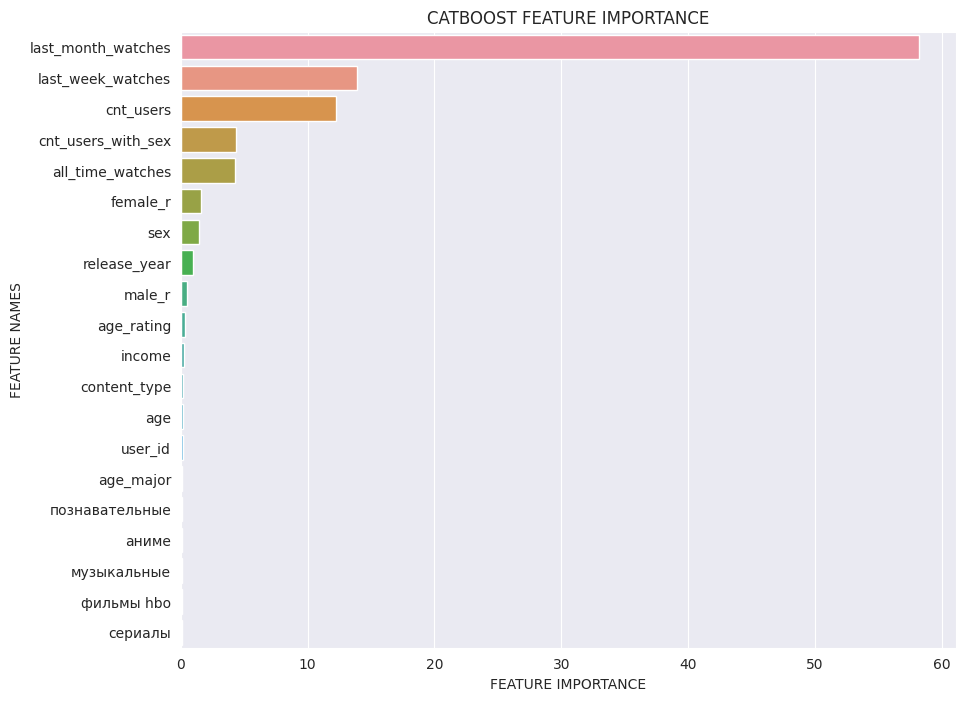

In [349]:
plot_feature_importance(catboost_model.get_feature_importance(),X_train.drop(columns=['target']).columns,'CATBOOST')

интересно, что менее популярные жанры влияют больше чем драмы, комедии или боевики..

### результаты

не успеваю уже посидеть с катбустом, хочу хотя бы посчитать финальные метрики

In [ ]:
train1_users = train1['user_id'].unique()

In [ ]:
# для этих ребят можем применить двухэтапную модель, так как у них есть история
test_hot_users = test_part.loc[test_part['user_id'].isin(train1_users)].copy()

# у этих ребят истории нет, будем пользоваться эвристиками, например советовать самое популярное
test_cold_users = test_part.loc[~test_part['user_id'].isin(train1_users)].copy()

In [ ]:
# будем фильтровать то, что пользователь уже смотрел
to_filter = train_part.groupby('user_id')['item_id'].apply(list).reset_index().rename(columns={'item_id':'ground_truth'})

In [ ]:
test_hot_users['cosine_recs'] = cosine_model.predict(test_hot_users, topn=30, to_filter=to_filter)

predicting:   0%|          | 0/10488 [00:00<?, ?it/s]

In [285]:
hot_users_tupels = []
for user in tqdm(test_hot_users['user_id'].unique()):
    vals = test_hot_users.loc[test_hot_users['user_id'] == user, 'cosine_recs'].values[0].tolist()
    uids = [user] * len(vals)
    hot_users_tupels += (list(zip(uids, vals)))

  0%|          | 0/10488 [00:00<?, ?it/s]

In [287]:
hot_users_data = pd.DataFrame(hot_users_tupels, columns=['user_id', 'item_id'])

In [288]:
hot_users_data.head()

,user_id,item_id
0,30,16515
1,30,16232
2,30,10887
3,30,10381
4,30,9155


In [289]:
# добвляем косинусное растояние из модели als первого этапа

for user_id in tqdm(hot_users_data['user_id'].unique()):
    items = hot_users_data.loc[hot_users_data['user_id'] == user_id, 'item_id'].values
    enc_user = als.user_encoder.transform([user])[0]
    enc_items = als.item_encoder.transform(items)
    cos_dist = (als.model.user_factors[enc_user] @ als.model.item_factors[enc_items].T) / (np.linalg.norm(als.model.user_factors[enc_user]) * np.linalg.norm(als.model.item_factors[enc_items], ord=2, axis=1))
    hot_users_data.loc[hot_users_data['user_id'] == user_id, 'cos_dist'] = cos_dist

  0%|          | 0/10484 [00:00<?, ?it/s]

In [290]:
# добавляем признаки из табличек с юзерами и айтемами

hot_users_data = hot_users_data.merge(
    users_df,
    how='left',
    on='user_id'
)

hot_users_data = hot_users_data.merge(
    items_df,
    how='left',
    on='item_id'
)

In [292]:
hot_users_data.loc[hot_users_data['content_type'] == 'series', 'content_type'] = 0
hot_users_data.loc[hot_users_data['content_type'] == 'film', 'content_type'] = 1

hot_users_data.loc[hot_users_data['sex'] == 'М', 'sex'] = 0
hot_users_data.loc[hot_users_data['sex'] == 'Ж', 'sex'] = 1

In [293]:
for categ_column in categ:
    hot_users_data[categ_column].fillna('', inplace=True)

In [294]:
hot_users_data.sort_values('user_id', inplace=True)

In [300]:
hot_users_data.drop(columns='level_0', inplace=True)

In [ ]:
cols.remove('target')

In [309]:
final_pool = catboost.Pool(hot_users_data[cols], cat_features=categ, group_id=hot_users_data['user_id'])

In [311]:
hot_users_data['probs'] = catboost_model.predict_proba(final_pool)[:, 1]

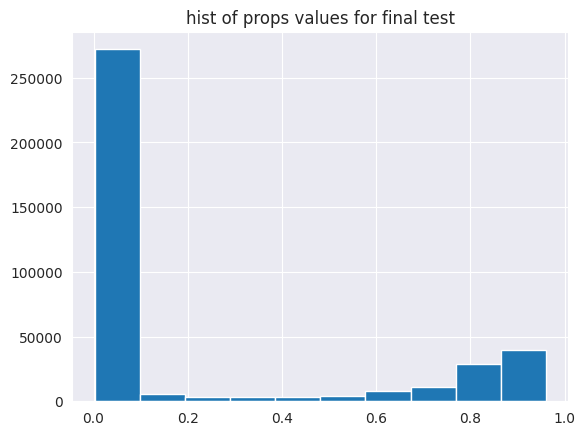

In [313]:
plt.hist(hot_users_data['probs'])
plt.title('hist of props values for final test')
plt.show()

In [315]:
hot_users_data.head()

,user_id,item_id,cos_dist,age,income,sex,kids_flg,income_int,age_int,content_type,...,Мексика,Нидерланды,Казахстан,Гонконг,Ирландия,Индия,Венгрия,Польша,Турция,probs
0,30,16515,0.014473,,,NaN,NaN,NaN,NaN,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.006546
32,30,14345,0.007347,,,NaN,NaN,NaN,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.184680
31,30,14761,0.013231,,,NaN,NaN,NaN,NaN,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008476
30,30,11618,0.017388,,,NaN,NaN,NaN,NaN,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008086
29,30,8908,0.009255,,,NaN,NaN,NaN,NaN,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007863


In [325]:
k=10
recs = []
for user in tqdm(test_hot_users['user_id'].unique()):
    items = hot_users_data.loc[hot_users_data['user_id'] == user].sort_values('probs', ascending=False)['item_id'].values[:k]
    recs.append(items)

  0%|          | 0/10488 [00:00<?, ?it/s]

In [327]:
test_hot_users['my_recs'] = recs

In [329]:
test_cold_users['my_recs'] = test_cold_users['toppopular_recs']

In [331]:
test_hot_users = test_hot_users.append(test_cold_users)

In [332]:
print('final score on my two-step model:')
print(evaluate_recommender(df=test_hot_users, model_preds_col="my_recs"))

final score on my two-step model:
{'ndcg': 0.1336323612501178, 'recall': 0.059134082126785524}


In [336]:
catboost_model.save_model('/content/drive/MyDrive/ml_tink/catboost_model')

# Так что же нужно сделать?

### tl;dr – красивые визуализации, креативные подходы, различные модели

**Мы не ставим перед вами задачу выбить лучший скор на тестовой выборке** (хотя это очень желательно), задание скорее в том, чтобы исследовать различные подходы, поискать инсайты в данных, построить красивый анализ своих предсказаний и поиграться с данными.

Если говорить более формально, то мы будем оценивать следующее:
1. Какие методы вы попробовали для решения задачи
   ##### Это могут быть
   * статистически подходы, основанные на вашем анализе данных
   * классические метрические методы, вроде knn, а как посчитать вектора пользователей – пусть уже ваша фантазия вам диктует. Здесь вам помогут item-based модели, вроде EASE или SLIM
   * затюненный или модифицированный ALS (ну или любая другая модель матричной факторизации)
   * классические модели вроде градиентных бустингов (catboost, lightGBM) тоже работают в таких задачах (вам ведь ничего не мешает учить классификатор на просмотренный и непросмотренный фильмы, правда? осталось только насэмплить вторых)
   * очень приветствуются (но не обязательны) DL подходы, например [DSSM](https://kishorepv.github.io/DSSM/), [NCF](https://towardsdatascience.com/neural-collaborative-filtering-96cef1009401), [Bert4Rec](https://towardsdatascience.com/build-your-own-movie-recommender-system-using-bert4rec-92e4e34938c5) или [любой другой алгоритм](https://habr.com/ru/companies/prequel/articles/573880/), который вы найдете, например графовые или дифузионные подходы, почему нет)
     
   В общем нет никаких ограничений на модели, используйте то, что вам нравится или кажется логичным. Не стоит бросаться в крайности: обучать целый зоопарк моделей или затюнить одну до 0 ошибки. Найдите баланс между количеством и качеством)
2. Как хорошо вы валидировали свои модели
3. EDA (Exploration Data Analysis) данных, с которыми вы работаете
4. EDA полученных рекомендаций, насколько они разнообразные, насколько смещены в сторону популярных айтемов и всякое такое
5. **Обязательно** сохраните свою лучшую модель (файлик обученной модели), чтобы мы могли воспроизвести ваш результат!


## Помните:
1. Все дополнительные источники данных **обязательно** должны быть описаны
2. Нет правильного способа решить задачу. Не стоит беспокоиться, что вы делаете что-то неправильно. Мы хотим увидеть творческий подход и ваши способности к исследованию и прототипированию, а не какое-то конкретное решение задачи.
3. Вы можете использовать любые библиотеки и фреймворки, которые вам могут быть необходимы.
4. Сфокусируйтесь на том, чтобы код были чистый и понятный. Если вы считаете, что какая-то его часть может быть непонятна, то добавьте комментарии. Мы очень сильно ценим хорошо написанный код и выводы, поэтому если решение задачи будет оформлено грязно, то мы можем отклонить заявку.

## Результат
Мы ожидаем увидеть один или два (EDA + обучение моделей) ноутбук(а) на вашем [GitHub](https://github.com/) или ссылками на ваш [Google Colab](https://colab.research.google.com/?hl=ru).
